# Load modules
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?)  

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 179 GB / percent used: 29.0 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'tas'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'
    
var_label = 'Near-Surface Air Temperature [°C]'
var_label_trends = 'Near-Surface Air Temperature trends [°C/dec]'
var_label_bias = 'Near-Surface Air Temperature bias [°C]'
cmap='CoolWarm'
levels=plot.arange(-30,30,5)

# Load ensemble mean
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [3]:
realization = 'ens'
# Load historical ens
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)
# Load amip ens
experiment='amip'
da_amip = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

## Convert units

In [11]:
da_historical = da_historical-273.15
da_amip = da_amip-273.15
da_land_hist = da_land_hist-273.15
da_HR = da_HR-273.15

# Load obs

## cru_ts4.00
More recent version available: https://crudata.uea.ac.uk/cru/data/hrg/  
-> pas évident à télécharger encore... les netCDF ne sont pas reconnus directement, je vais rester du coup sur la version 4.00  

```bash
cdo mergetime /bdd/cru/cru_ts_4.00/data/tmp/*.nc /data/mlalande/CRU/tmp/cru_ts4.00.1901.2015.tmp.dat.nc 
```

(pas plus rapide...)

Du coup je vais rester avec le open_mfdataset (même si le time n'est pas bien reconnu d'où le découpage à la main avec le isel)

In [22]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

In [23]:
obs = xr.open_mfdataset(
    '/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.*.tmp.dat.nc', combine='nested', concat_dim='time'
).isel(
    time=slice(1080,1488)
).tmp
obs

<xarray.DataArray 'tmp' (time: 408, lat: 360, lon: 720)>
dask.array<getitem, shape=(408, 360, 720), dtype=float32, chunksize=(408, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * time     (time) datetime64[ns] 1981-01-16 1981-02-15 ... 2014-12-16
Attributes:
    long_name:                   near-surface temperature
    units:                       degrees Celsius
    correlation_decay_distance:  1200.0

### Regrid using xESMF (https://xesmf.readthedocs.io/en/latest/) 

In [24]:
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=True, reuse_weights=True)
obs_regrid = regridder_obs(obs)

Reuse existing file: bilinear_360x720_143x144_peri.nc


### Regrid HR

In [15]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_HR)

# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


## Load ERA-Interim
- ERA-Interim (https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era-interim)

In [16]:
era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/t2.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).t2.sel(time=period).load()
era

<xarray.DataArray 't2' (time: 408, lat: 241, lon: 480)>
array([[[242.11598, 242.11598, 242.11598, ..., 242.11598, 242.11598,
         242.11598],
        [241.79372, 241.78395, 241.77614, ..., 241.82692, 241.8152 ,
         241.80348],
        [241.85622, 241.84059, 241.82301, ..., 241.91676, 241.89723,
         241.8777 ],
        ...,
        [250.97926, 250.95778, 250.9363 , ..., 251.03395, 251.01637,
         250.99684],
        [250.63942, 250.62575, 250.61403, ..., 250.66676, 250.657  ,
         250.64919],
        [249.80348, 249.80348, 249.80348, ..., 249.80348, 249.80348,
         249.80348]],

       [[247.91568, 247.91568, 247.91568, ..., 247.91568, 247.91568,
         247.91568],
        [247.76724, 247.76138, 247.75552, ..., 247.78677, 247.78091,
         247.7731 ],
        [247.85513, 247.84146, 247.82974, ..., 247.89029, 247.87857,
         247.86685],
        ...,
        [239.3024 , 239.28677, 239.27115, ..., 239.34341, 239.32974,
         239.31607],
        [239.52701, 239.51724, 239.50748, ..., 239.54068, 239.53677,
         239.53091],
        [238.89029, 238.89029, 238.89029, ..., 238.89029, 238.89029,
         238.89029]],

       [[247.08379, 247.08379, 247.08379, ..., 247.08379, 247.08379,
         247.08379],
        [247.04472, 247.04668, 247.04863, ..., 247.04082, 247.04082,
         247.04277],
        [247.28691, 247.28886, 247.28886, ..., 247.28691, 247.28691,
         247.28691],
        ...,
        [227.60527, 227.59355, 227.58379, ..., 227.63457, 227.6248 ,
         227.61504],
        [227.16386, 227.15605, 227.14824, ..., 227.16777, 227.16582,
         227.16582],
        [225.87871, 225.87871, 225.87871, ..., 225.87871, 225.87871,
         225.87871]],

       ...,

       [[260.47632, 260.47632, 260.47632, ..., 260.47632, 260.47632,
         260.47632],
        [260.95093, 260.9568 , 260.96265, ..., 260.9314 , 260.93726,
         260.94507],
        [261.51733, 261.52905, 261.54272, ..., 261.4685 , 261.48413,
         261.5017 ],
        ...,
        [225.78294, 225.77122, 225.75755, ..., 225.822  , 225.80833,
         225.79662],
        [225.49974, 225.49193, 225.48607, ..., 225.51146, 225.50755,
         225.50365],
        [224.86888, 224.86888, 224.86888, ..., 224.86888, 224.86888,
         224.86888]],

       [[251.7468 , 251.7468 , 251.7468 , ..., 251.7468 , 251.7468 ,
         251.7468 ],
        [251.26047, 251.27023, 251.28   , ..., 251.23898, 251.2468 ,
         251.25461],
        [250.89328, 250.91086, 250.92844, ..., 250.83469, 250.85422,
         250.87375],
        ...,
        [240.02023, 240.01242, 240.00461, ..., 240.03976, 240.0339 ,
         240.0261 ],
        [239.54758, 239.54172, 239.53586, ..., 239.55344, 239.55148,
         239.54953],
        [238.75266, 238.75266, 238.75266, ..., 238.75266, 238.75266,
         238.75266]],

       [[251.68416, 251.68416, 251.68416, ..., 251.68416, 251.68416,
         251.68416],
        [251.81111, 251.82088, 251.8326 , ..., 251.78181, 251.79158,
         251.80135],
        [252.1197 , 252.13728, 252.15486, ..., 252.06306, 252.0826 ,
         252.10213],
        ...,
        [250.10603, 250.08846, 250.07283, ..., 250.14119, 250.12947,
         250.11775],
        [249.4322 , 249.42244, 249.41072, ..., 249.45174, 249.44588,
         249.44002],
        [248.40096, 248.40096, 248.40096, ..., 248.40096, 248.40096,
         248.40096]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * time     (time) datetime64[ns] 1981-01-01 1981-02-01 ... 2014-12-01
Attributes:
    long_name:     2 metre temperature
    units:         degK
    num_GRIB:      167
    level_desc:    Surface
    dataset:       Analysis
    actual_range:  [200.492 312.199]

### Convert units

In [17]:
era = era-273.15

### Regrid

In [18]:
regridder_ERAI = xe.Regridder(era, da_historical, 'bilinear', periodic=True, reuse_weights=True)
era_regrid = regridder_ERAI(era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Annual Climatology
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [19]:
season = 'JJAS'

In [25]:
latlim=(10,50)
lonlim=(60,110)

da_historical_clim = u.custom_season_clim(da_historical.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
da_historical_clim.load()

da_amip_clim = u.custom_season_clim(da_amip.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
da_amip_clim.load()

da_land_hist_clim = u.custom_season_clim(da_land_hist.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
da_land_hist_clim.load()

da_HR_regrid_clim = u.custom_season_clim(da_HR_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
da_HR_regrid_clim.load()

da_HR_clim = u.custom_season_clim(da_HR.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
da_HR_clim.load()

obs_regrid_clim = u.custom_season_clim(obs_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
obs_regrid_clim.load()

obs_clim = u.custom_season_clim(obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
obs_clim.load()

era_regrid_clim = u.custom_season_clim(era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
era_regrid_clim.load()

era_clim = u.custom_season_clim(era.sel(lat=slice(latlim[1],latlim[0]), lon=slice(lonlim[0],lonlim[1])), season=season)
era_clim.load()

<xarray.DataArray (lat: 53, lon: 67)>
array([[20.37382541, 20.77543603, 21.09411371, ..., 12.71582287,
        12.32030141, 12.09865892],
       [21.21575695, 21.68020094, 21.98995819, ..., 11.79170941,
        11.83482695, 12.3506224 ],
       [21.96119715, 22.29094803, 22.61091021, ..., 12.40776402,
        12.83145654, 13.70084436],
       ...,
       [27.11853531, 27.20620227, 27.30521554, ..., 24.26435859,
        25.93569116, 28.02671159],
       [27.20380042, 27.30177638, 27.41512826, ..., 25.19011301,
        26.41885511, 28.06949953],
       [27.30075179, 27.41011973, 27.51981256, ..., 27.29578375,
        27.68555273, 28.1244347 ]])
Coordinates:
  * lat      (lat) float64 49.5 48.75 48.0 47.25 46.5 ... 12.75 12.0 11.25 10.5
  * lon      (lon) float64 60.0 60.75 61.5 62.25 ... 107.2 108.0 108.8 109.5
    season   <U4 'JJAS'

In [26]:
# We remove HR for keeping the resolution

concat = xr.concat(
    [
        da_historical_clim,
        da_amip_clim,
        da_land_hist_clim,
    ],
    pd.Index(
        [
            'Historical (32)',
            'AMIP (21)',
            'land-hist (1)',
        ], 
        name='exp'
    )
)

/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/proplot/styletools.py:2855: RuntimeWarning: invalid value encountered in true_divide
  distance = (xq - x[idx - 1]) / (x[idx] - x[idx - 1])
/data/mlalande/miniconda3/envs/work/lib/python3.8/site-packages/proplot/styletools.py:2855: RuntimeWarning: invalid value encountered in true_divide
  distance = (xq - x[idx - 1]) / (x[idx] - x[idx - 1])


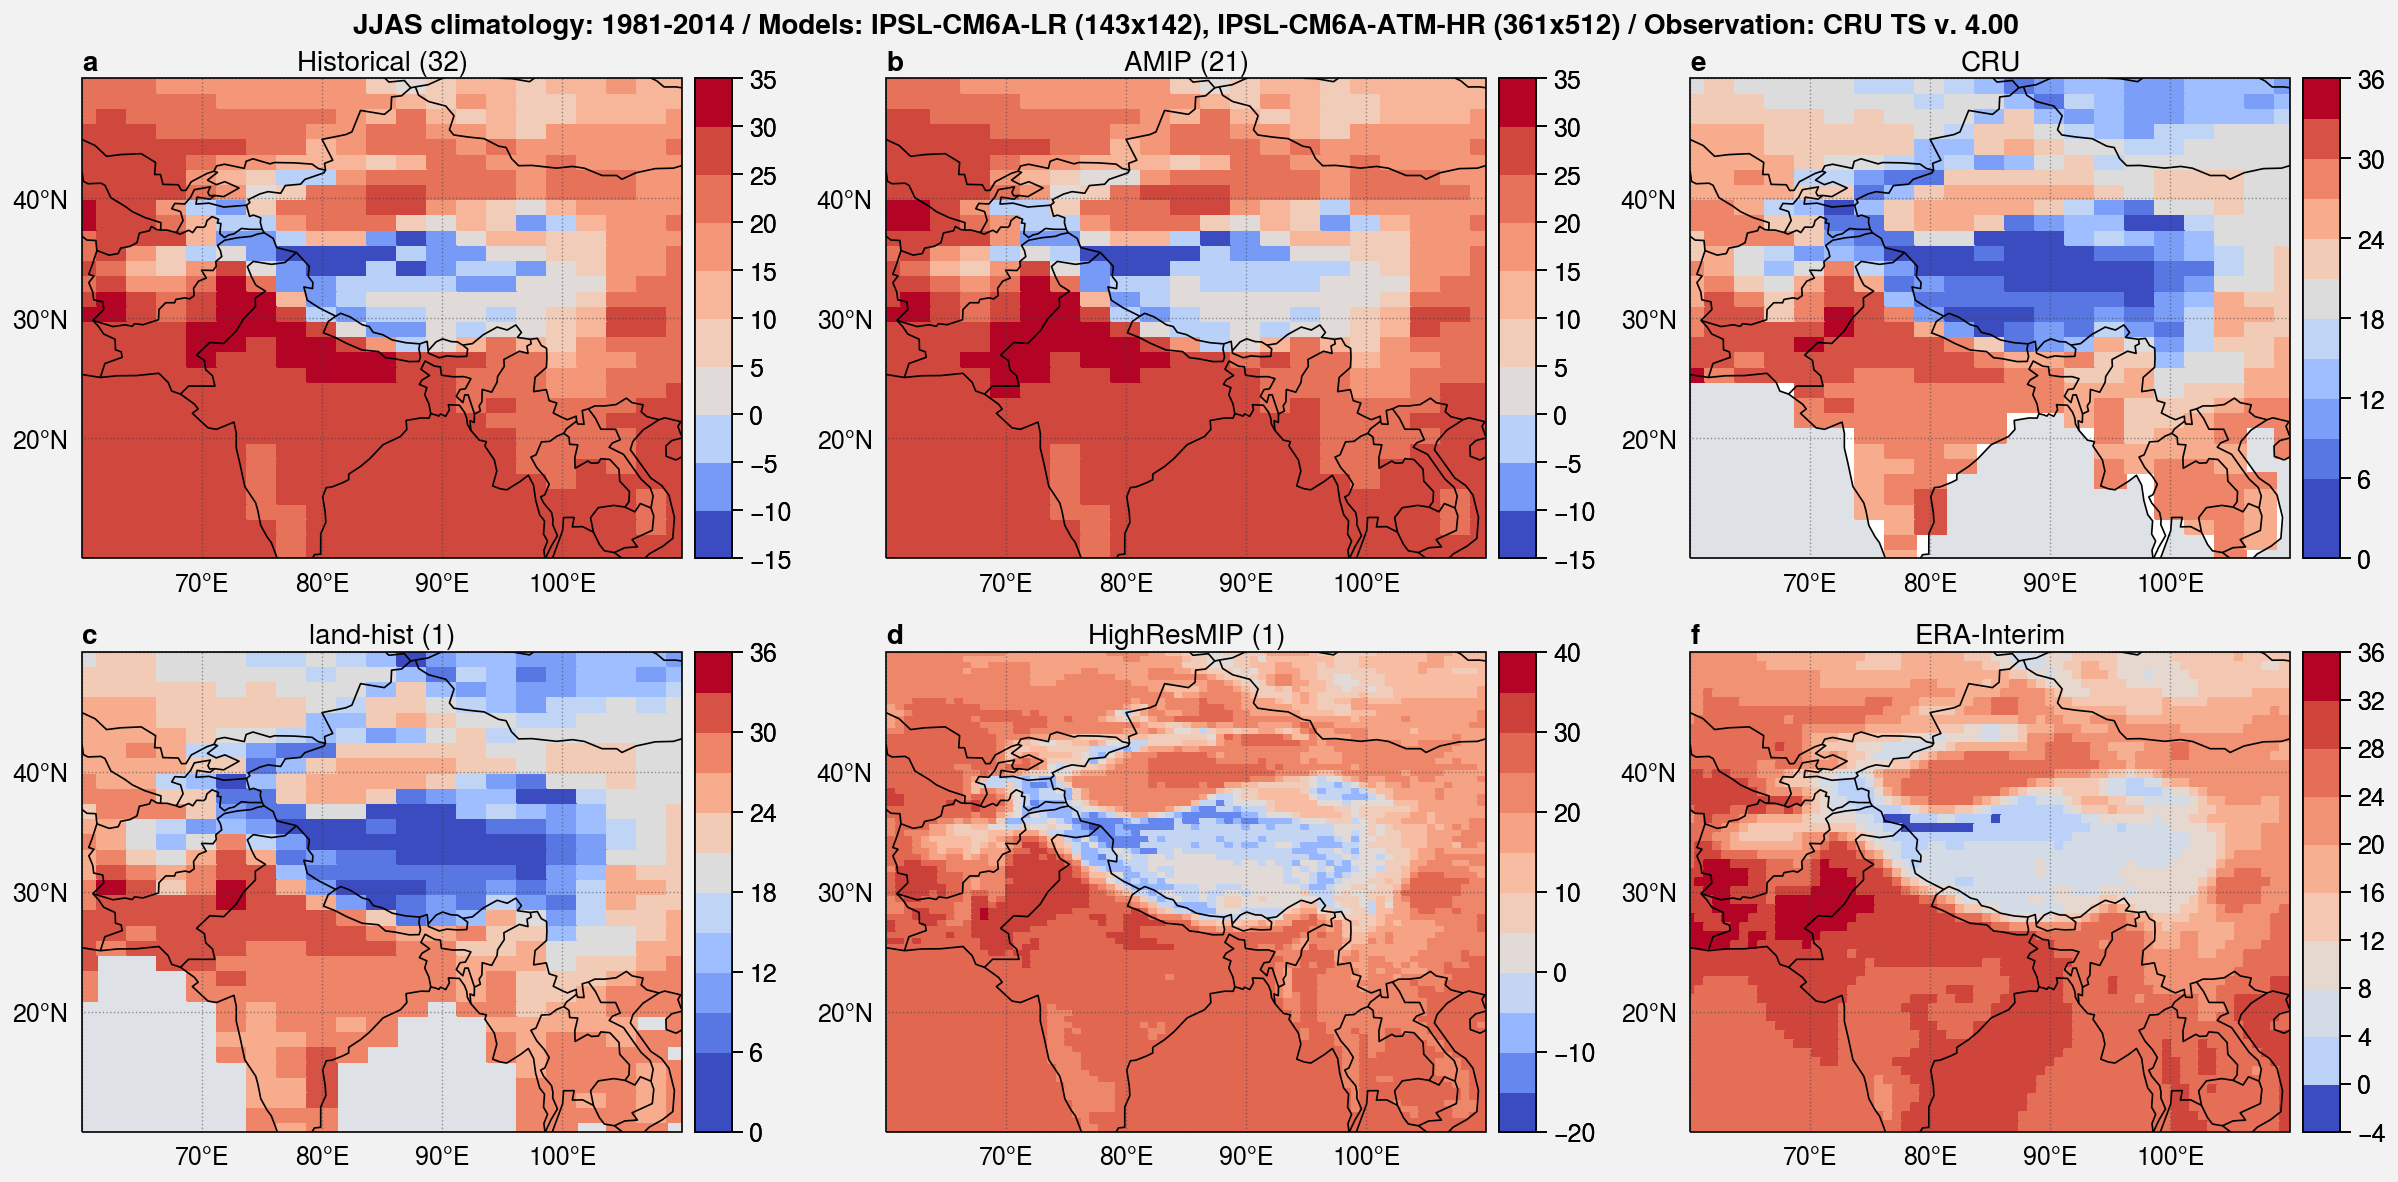

In [36]:
#Check colorbars 

f, axs = plot.subplots([[1, 2, 5], [3, 4, 6]], proj='cyl', share=3, axwidth=3)

for i, ax in enumerate(axs):
    if i < 3:
        m = ax.pcolormesh(concat.isel(exp=i), cmap=cmap, colorbar='r', norm='midpoint')
        ax.format(title=str(concat.isel(exp=i).exp.values))
    
axs[3].pcolormesh(da_HR_clim, cmap=cmap, colorbar='r', norm='midpoint')
axs[3].format(title='HighResMIP (1)') 

axs[4].pcolormesh(obs_regrid_clim, cmap=cmap, colorbar='r', norm='midpoint')
axs[4].format(title=obs_name)

axs[5].pcolormesh(era_clim, cmap=cmap, colorbar='r', norm='midpoint')
axs[5].format(title='ERA-Interim')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="JJAS climatology: 1981-2014 / Models: IPSL-CM6A-LR (143x142), IPSL-CM6A-ATM-HR (361x512) / Observation: "+obs_longname,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

In [28]:
concat.max()

<xarray.DataArray ()>
array(34.58373084)
Coordinates:
    height   float64 2.0
    season   <U4 'JJAS'

In [29]:
obs_regrid_clim.max()

<xarray.DataArray ()>
array(33.11512871)
Coordinates:
    season   <U4 'JJAS'

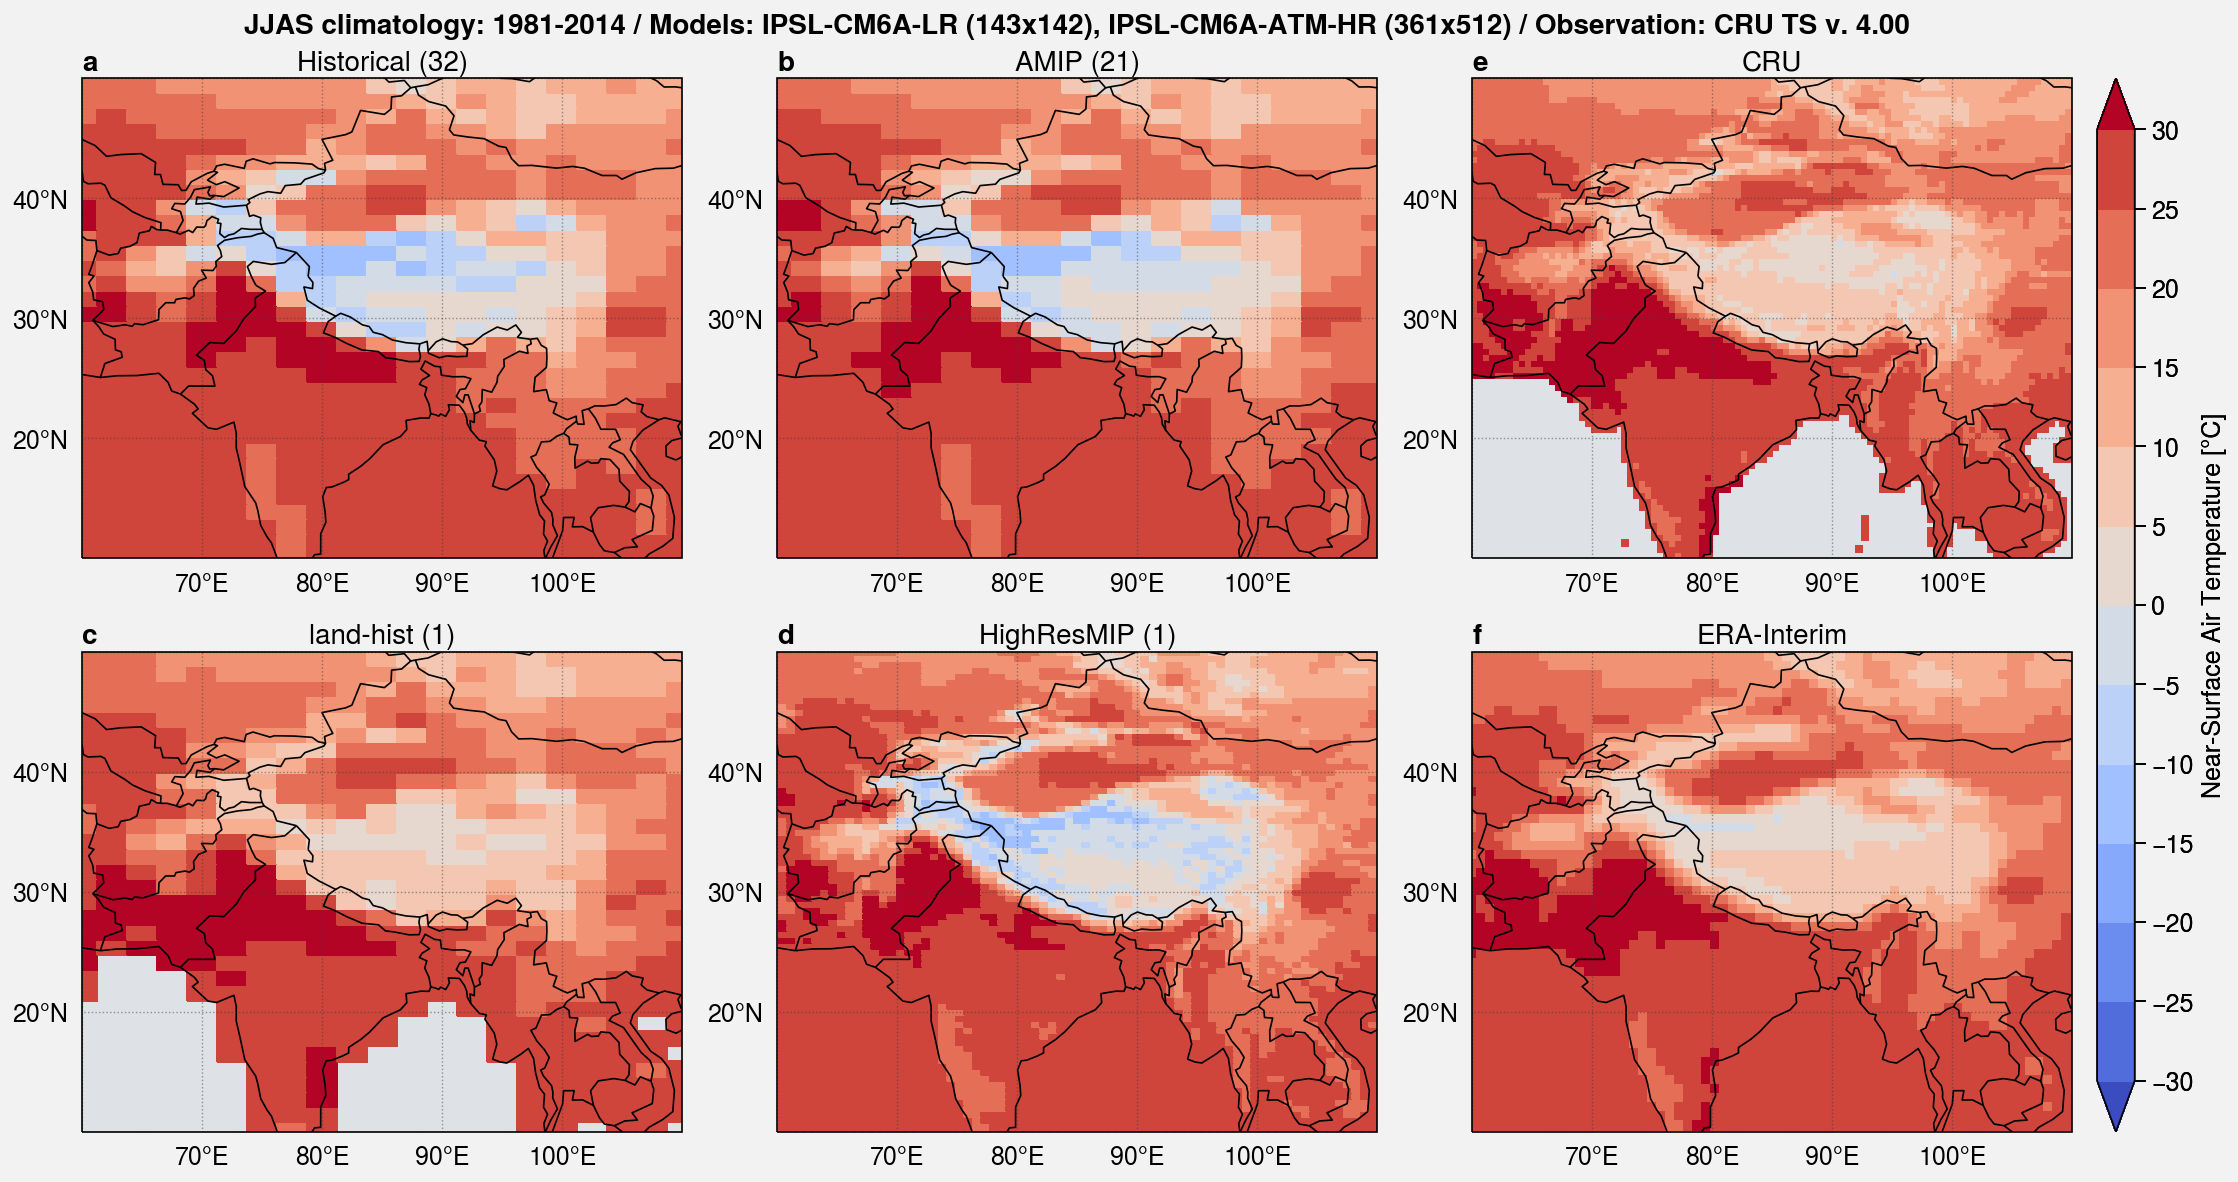

In [43]:
# Final plot

f, axs = plot.subplots([[1, 2, 5], [3, 4, 6]], proj='cyl', share=3, axwidth=3)

extend='both'

for i, ax in enumerate(axs):
    if i < 3:
        m = ax.pcolormesh(concat.isel(exp=i), cmap=cmap, levels=levels, extend=extend, norm='midpoint')
        ax.format(title=str(concat.isel(exp=i).exp.values))
    
axs[3].pcolormesh(da_HR_clim, cmap=cmap, levels=levels, extend=extend, norm='midpoint')
axs[3].format(title='HighResMIP (1)') 

axs[4].pcolormesh(obs_clim, cmap=cmap, levels=levels, extend=extend, norm='midpoint')
axs[4].format(title=obs_name) 

axs[5].pcolormesh(era_clim, cmap=cmap, levels=levels, extend=extend, norm='midpoint')
axs[5].format(title='ERA-Interim')

f.colorbar(m, label=var_label)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=season+" climatology: 1981-2014 / Models: IPSL-CM6A-LR (143x142), IPSL-CM6A-ATM-HR (361x512) / Observation: "+obs_longname,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/'+season+'_clim_'+var+'_IPSL_CMIP6.png')
# f.save('img/'+var+'/'+season+'_clim_'+var+'_IPSL_CMIP6.pdf')

# Bias
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
[#Link-with-orography?](#Link-with-orography?) 

In [39]:
bias = xr.concat(
    [
        (da_historical_clim-obs_regrid_clim),
        (da_amip_clim-obs_regrid_clim),
        (da_land_hist_clim-obs_regrid_clim),
        (da_HR_regrid_clim-obs_regrid_clim)
    ],
    pd.Index(
        [
            'Historical (32) - '+obs_name,
            'AMIP (21) - '+obs_name,
            'land-hist (1) - '+obs_name,
            'HighResMIP (1) - '+obs_name
        ], 
        name='bias'
    )
)

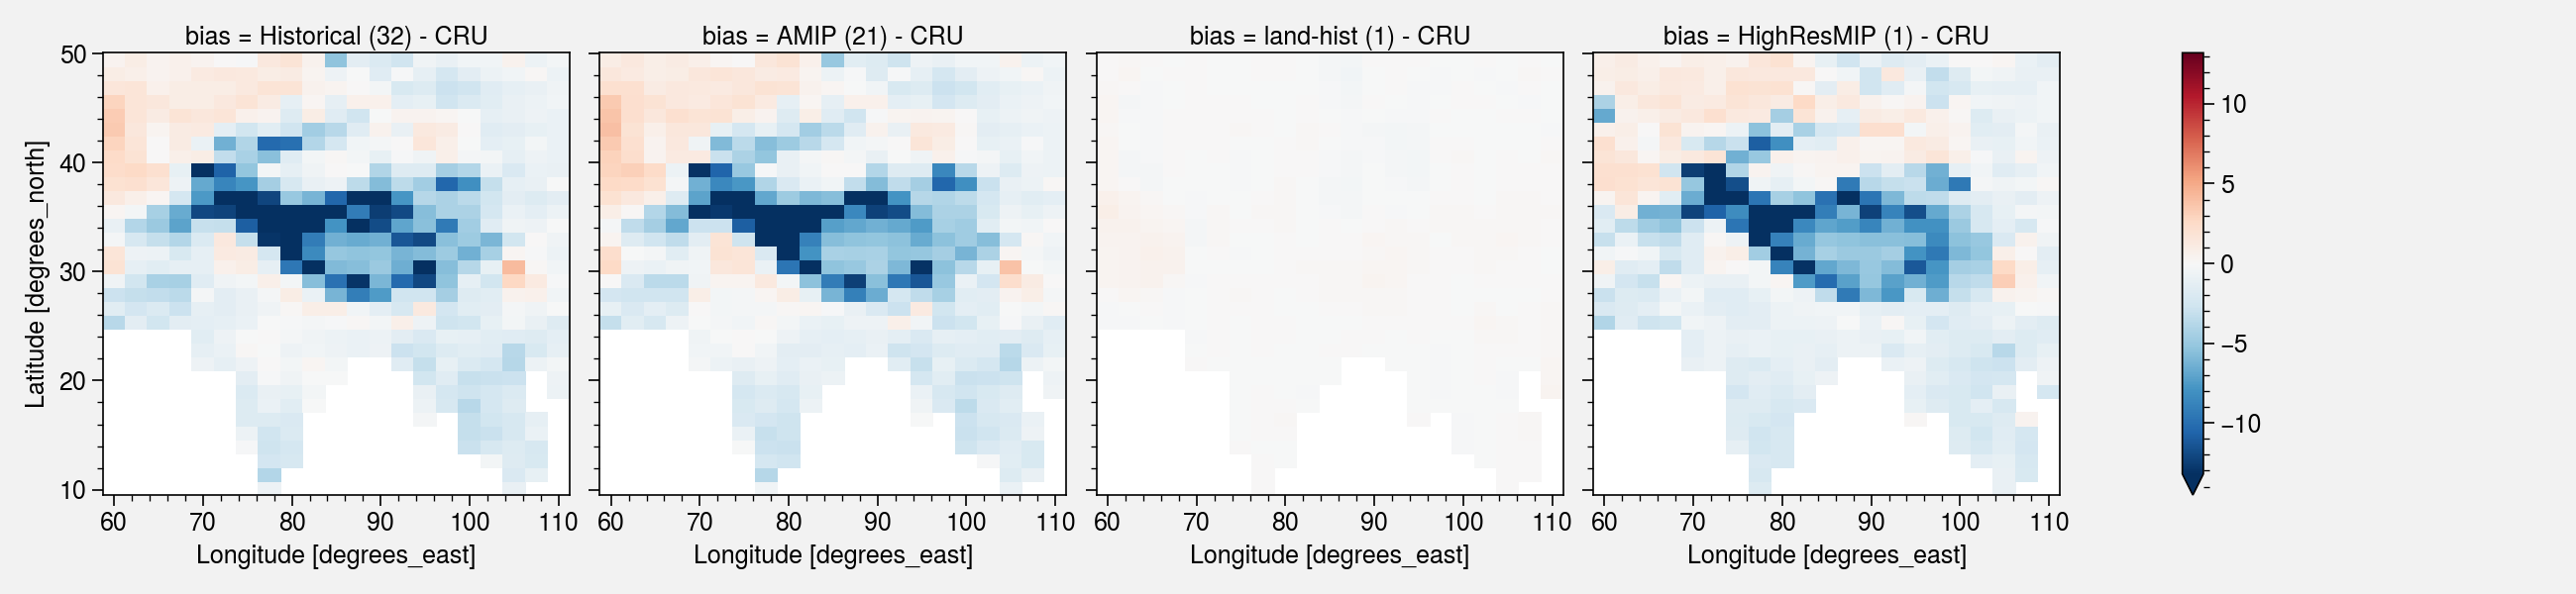

In [40]:
bias.plot(col='bias', robust=True)

In [41]:
bias.min()

<xarray.DataArray ()>
array(-19.41704399)
Coordinates:
    height   float64 2.0
    season   <U4 'JJAS'

In [42]:
bias.max()

<xarray.DataArray ()>
array(4.13355134)
Coordinates:
    height   float64 2.0
    season   <U4 'JJAS'

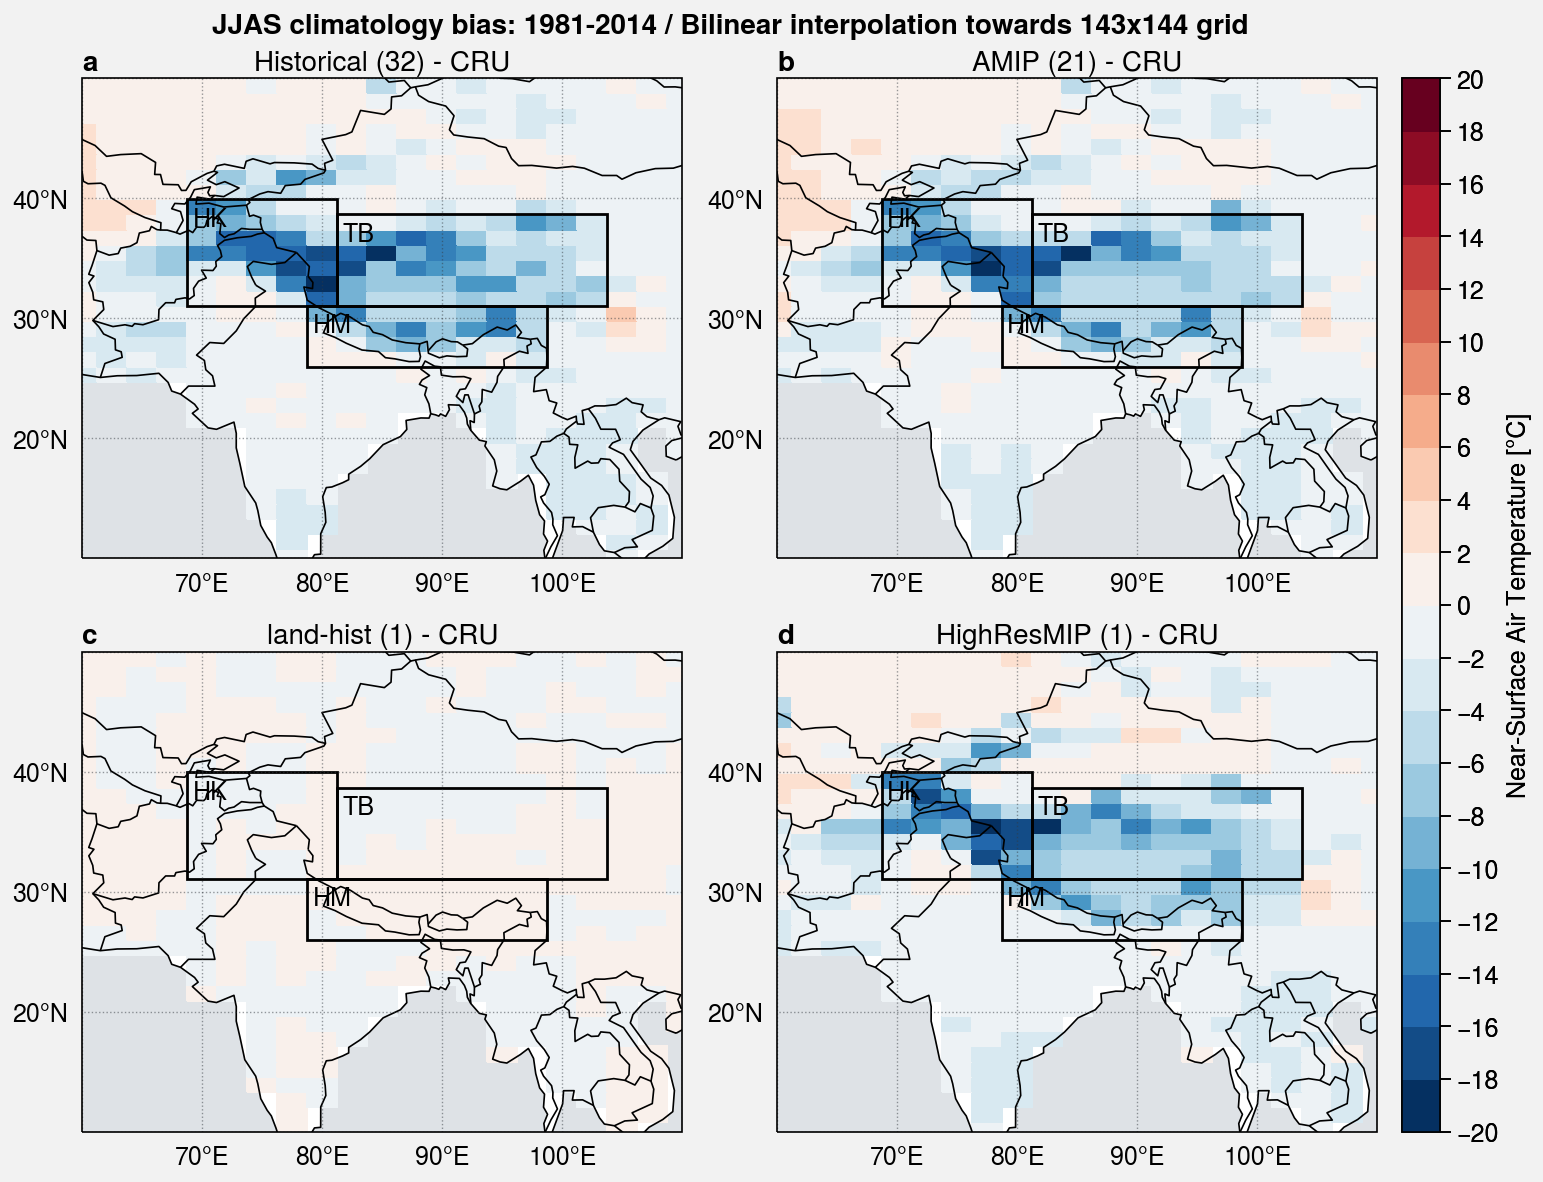

In [45]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=3)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu_r', 
        levels=plot.arange(-20,20,2), 
#         extend='both',
#         norm='midpoint'
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

f.colorbar(m, label=var_label)

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=season+" climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias_'+season+'.png')
# f.save('img/'+var+'/'+var+'_IPSL_CMIP6_bias_'+season+'.pdf')

# Link with orography?
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Link-with-orography?](#Link-with-orography?)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)   

In [46]:
# Get orog files
orog = xr.open_dataarray(
    '/bdd/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/fx/orog/gr/latest/orog_fx_IPSL-CM6A-LR_historical_r1i1p1f1_gr.nc'
).sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
orog

mean_topo = xr.open_dataarray('mean_topo.nc').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
std_topo = xr.open_dataarray('std_topo.nc').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))

# Zones
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TB, latlim_TB = u.get_zones_IPSL_CM6A_LR()

titles = ['HK', 'HM', 'TB']
zone_slices = [
    [slice(lonlim_HK[0],lonlim_HK[1]), slice(latlim_HK[0],latlim_HK[1])],
    [slice(lonlim_HM[0],lonlim_HM[1]), slice(latlim_HM[0],latlim_HM[1])],
    [slice(lonlim_TB[0],lonlim_TB[1]), slice(latlim_TB[0],latlim_TB[1])]
]

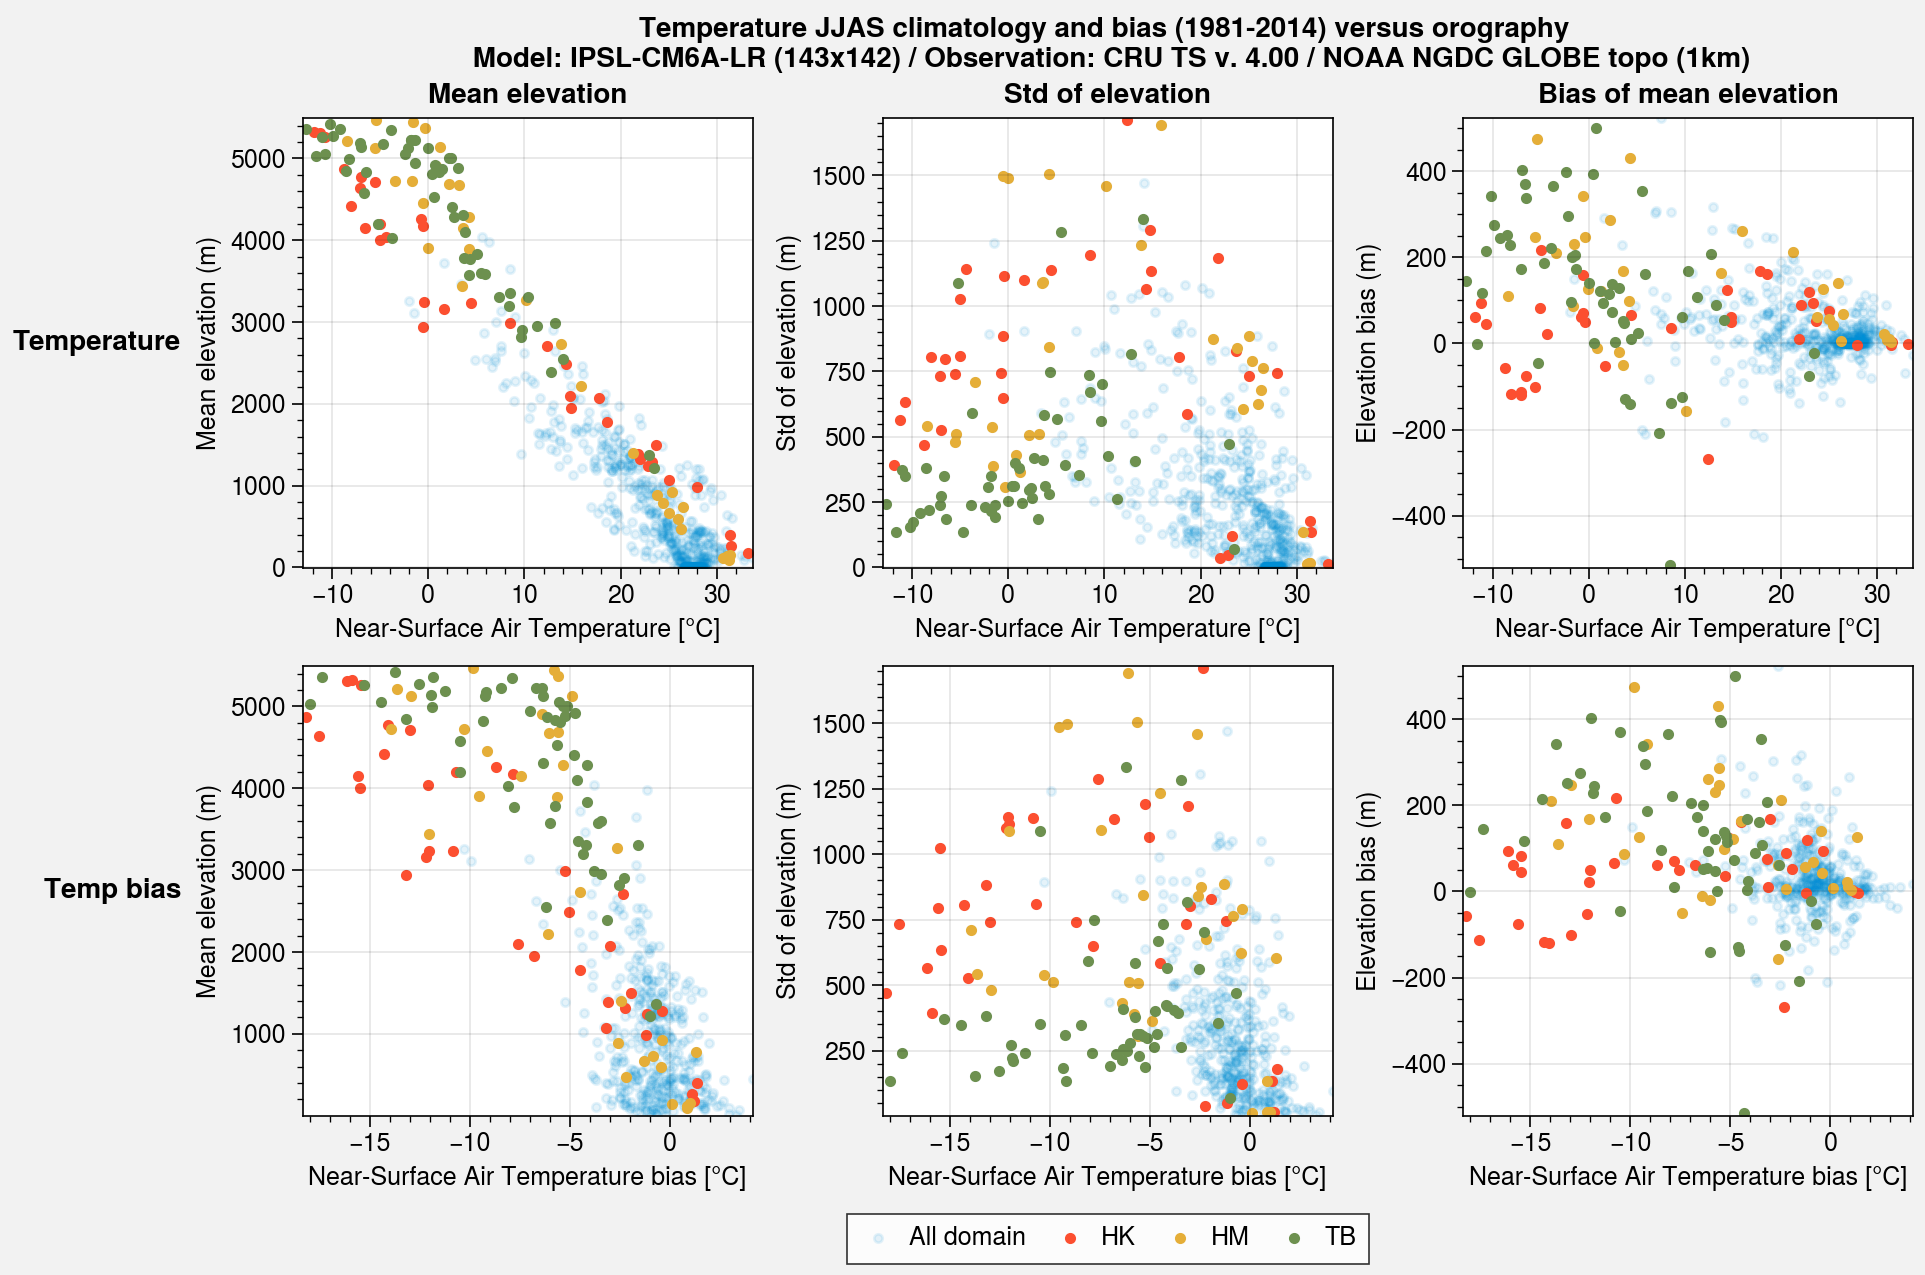

In [48]:
plot.rc.cycle = '538'

# Figure
f, axs = plot.subplots(nrows=2, ncols=3, share=0)

x = [concat[0], bias[0]]
xlabels = [var_label, var_label_bias]
y = [orog, std_topo, (orog-mean_topo)]
ylabels = ['Mean elevation (m)', 'Std of elevation (m)', 'Elevation bias (m)']

for i, ax in enumerate(axs):
    # ALL
    h1 = ax.scatter(x[i//3].values.flatten(), y[i%3].values.flatten(), alpha=0.1, label='All domain')
    # HK
    h2 = ax.scatter(
        x[i//3].sel(lon=zone_slices[0][0], lat=zone_slices[0][1]).values.flatten(), 
        y[i%3].sel(lon=zone_slices[0][0], lat=zone_slices[0][1]).values.flatten(), 
        label=titles[0]
    )
    # HM
    h3 = ax.scatter(
        x[i//3].sel(lon=zone_slices[1][0], lat=zone_slices[1][1]).values.flatten(), 
        y[i%3].sel(lon=zone_slices[1][0], lat=zone_slices[1][1]).values.flatten(), 
        label=titles[1]
    )
    # TB
    h4 = ax.scatter(
        x[i//3].sel(lon=zone_slices[2][0], lat=zone_slices[2][1]).values.flatten(), 
        y[i%3].sel(lon=zone_slices[2][0], lat=zone_slices[2][1]).values.flatten(), 
        label=titles[2]
    )
    ax.format(xlabel=xlabels[i//3], ylabel=ylabels[i%3])

axs.format(
    suptitle='Temperature '+season+' climatology and bias (1981-2014) versus orography \n Model: IPSL-CM6A-LR (143x142) / Observation: '+obs_longname+' / NOAA NGDC GLOBE topo (1km)',
    collabels=['Mean elevation', 'Std of elevation', 'Bias of mean elevation'],
    rowlabels=['Temperature', 'Temp bias']
)

hs = [h1, h2, h3, h4]
f.legend(hs, loc='b', ncols=4, order='F', center=False, frame=True)

# f.save('img/'+var+'/orog_'+var+'_'+season+'.png')
# f.save('img/'+var+'/orog_'+var+'_'+season+'.pdf')

## Obs vs model

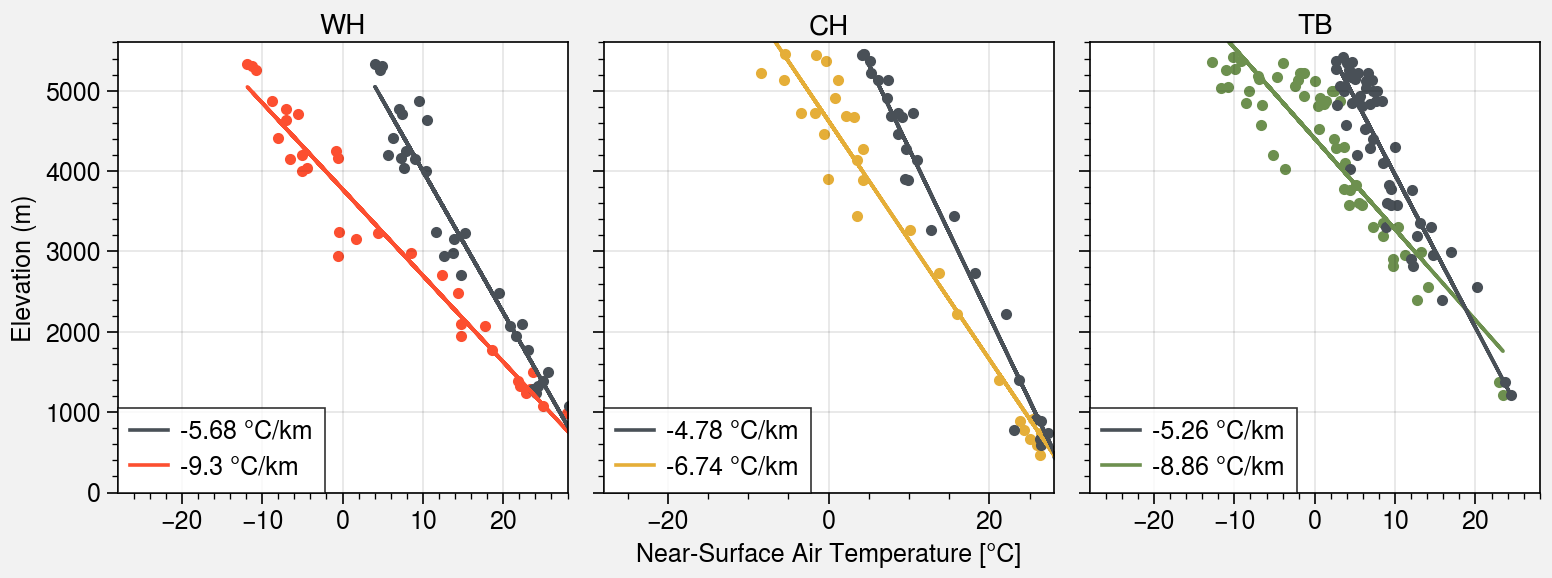

In [50]:
plot.rc.cycle = '538'

# Figure
f, axs = plot.subplots(nrows=1, ncols=3, share=3)
labels=['WH', 'CH', 'TB']
colors=['C1','C2','C3']

for i, ax in enumerate(axs):
    # Model
    ##########################
    x = concat[0].sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).values.flatten()
    y = orog.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).values.flatten()
    xlabels = var_label
    ylabels = 'Elevation (m)'
    
    ax.scatter(x, y, label=labels[i], color=colors[i])
    # Regression
    reg = stats.linregress(x, y)
    h1 = ax.plot(x, reg.intercept + reg.slope*x, color=colors[i], 
                 label=str(round(1/reg.slope*1000,2))+' °C/km')

    # Obs
    ###########################
    x = obs_regrid_clim.sel(lon=zone_slices[i][0], lat=zone_slices[i][1]).values.flatten()
    ax.scatter(x, y, label=labels[i], color='gray7')
    
    # regression
    reg = stats.linregress(x, y)
    h2 = ax.plot(x, reg.intercept + reg.slope*x, color='gray7', 
                 label=str(round(1/reg.slope*1000,2))+' °C/km')


    ax.format(xlabel=xlabels, ylabel=ylabels, xlim=(-28,28), ylim=(0,5600), title=labels[i])
    
    hs = [h1, h2]
    ax.legend(hs, loc='ll')
    

# f.save('img/'+var+'/orog_'+var+'_obs_model_'+season+'.png')
# f.save('img/'+var+'/orog_'+var+'_obs_model_'+season+'.pdf')

# Annual cycle ensemble mean
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Link-with-orography?](#Link-with-orography?)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)  
## Charger tout comme ça on fait les cycles annuels + time series avec le shading sur les 3 zones à la volé

In [71]:
plot.rc.cycle = 'colorblind'

realization = '*'
da_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='nested', concat_dim='realization', parallel=True
).sel(time=period, lon=slice(lonlim[0],lonlim[1]), lat=slice(latlim[0],latlim[1]))[var].load()

da_amip_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*-201412.nc', 
    combine='nested', concat_dim='realization', parallel=True
).sel(time=period, lon=slice(lonlim[0],lonlim[1]), lat=slice(latlim[0],latlim[1]))[var].load()

In [72]:
da_historical_ens

<xarray.DataArray 'tas' (realization: 32, time: 408, lat: 32, lon: 21)>
array([[[[298.107  , 298.4703 , 298.64993, ..., 298.1238 , 296.82358,
          296.91336],
         [297.59647, 297.91858, 298.15634, ..., 296.29028, 294.01282,
          295.88443],
         [296.95547, 297.38916, 297.63684, ..., 294.90826, 292.1061 ,
          295.14142],
         ...,
         [263.4299 , 262.90042, 262.06805, ..., 251.42998, 251.81947,
          253.60892],
         [261.37448, 260.0914 , 258.85587, ..., 251.06453, 249.34239,
          252.43982],
         [258.28683, 257.8643 , 257.371  , ..., 253.76755, 250.45332,
          249.0809 ]],

        [[297.32553, 297.74023, 298.09152, ..., 299.71957, 297.913  ,
          298.00372],
         [296.61072, 296.92386, 297.23825, ..., 299.8299 , 295.9696 ,
          297.40536],
         [295.8436 , 296.06345, 296.3579 , ..., 300.24463, 294.72888,
          296.68253],
         ...,
         [266.15198, 266.28787, 265.4907 , ..., 253.29274, 253.66405,
          255.58296],
         [263.99658, 263.9359 , 263.4132 , ..., 252.4541 , 251.65395,
          255.22427],
         [261.57425, 261.83008, 262.5221 , ..., 254.91539, 255.0414 ,
          252.98216]],

        [[297.36246, 297.56702, 297.75192, ..., 301.19244, 299.47495,
          299.21643],
         [296.86078, 297.08377, 297.2349 , ..., 301.1799 , 298.3506 ,
          298.9233 ],
         [296.3842 , 296.67685, 296.73145, ..., 301.36053, 297.09274,
          298.58127],
         ...,
         [273.35785, 273.12256, 272.59653, ..., 262.8909 , 262.0126 ,
          265.4414 ],
         [271.1301 , 271.09998, 269.74466, ..., 263.25848, 260.20026,
          263.8572 ],
         [269.0323 , 268.95825, 268.5059 , ..., 266.31708, 262.37805,
          261.44034]],

        ...,

        [[300.84827, 300.65454, 300.83594, ..., 300.66626, 301.18076,
          301.3209 ],
         [300.92383, 300.78366, 300.85358, ..., 299.81973, 298.28552,
          300.91153],
         [300.89676, 300.95523, 300.93732, ..., 299.95096, 297.51816,
          300.64526],
         ...,
         [284.61627, 284.43033, 283.08154, ..., 272.27   , 272.97562,
          275.652  ],
         [282.91638, 282.6857 , 281.76242, ..., 273.70383, 271.54102,
          273.7872 ],
         [282.11667, 282.60458, 280.97577, ..., 275.36087, 273.7865 ,
          272.14865]],

        [[299.95386, 300.22278, 300.60245, ..., 300.07687, 299.53882,
          299.36057],
         [299.85925, 300.14767, 300.4483 , ..., 299.95108, 296.87396,
          299.21255],
         [299.70248, 299.94907, 300.27057, ..., 300.4693 , 296.05765,
          299.23398],
         ...,
         [274.8526 , 274.4389 , 272.66534, ..., 260.69794, 259.92258,
          261.55713],
         [272.79276, 272.02258, 271.08893, ..., 261.3007 , 258.8586 ,
          259.48618],
         [269.747  , 270.6479 , 270.4788 , ..., 261.87897, 258.98486,
          257.64163]],

        [[297.838  , 298.50424, 299.13187, ..., 299.51404, 298.56647,
          298.47348],
         [297.0444 , 297.8243 , 298.54163, ..., 298.1663 , 295.75345,
          297.80338],
         [296.30734, 297.08447, 297.77588, ..., 297.0582 , 293.96408,
          297.23962],
         ...,
         [267.05133, 267.07028, 265.3791 , ..., 249.1235 , 247.99951,
          250.12137],
         [264.9529 , 262.728  , 262.46146, ..., 247.03087, 243.67065,
          249.07828],
         [262.29114, 261.18677, 261.53854, ..., 249.25737, 244.65547,
          243.81306]]],


       [[[296.28162, 297.08182, 297.63965, ..., 298.56406, 297.87686,
          297.93982],
         [295.55966, 296.2693 , 296.92978, ..., 297.12857, 295.56503,
          297.27603],
         [294.97815, 295.58264, 296.153  , ..., 296.79025, 294.35165,
          296.81476],
         ...,
         [259.34564, 260.11584, 257.63507, ..., 240.27211, 241.04507,
          242.77635],
         [256.39267, 255.92073, 254.37349, ..., 238.76387, 237.84875,
          241.91005],
         [253.55414, 253.98419

In [73]:
da_amip_ens

<xarray.DataArray 'tas' (realization: 21, time: 408, lat: 32, lon: 21)>
array([[[[298.77563, 299.05255, 299.31934, ..., 300.19995, 298.44006,
          297.72885],
         [298.5062 , 298.75662, 299.02573, ..., 299.5145 , 296.1172 ,
          297.45456],
         [298.23688, 298.40137, 298.4868 , ..., 298.89932, 294.5696 ,
          297.20914],
         ...,
         [262.55447, 263.3084 , 262.6791 , ..., 248.62502, 246.04553,
          248.4605 ],
         [260.16306, 260.977  , 261.37762, ..., 246.1637 , 243.09113,
          247.0525 ],
         [256.67783, 257.14053, 258.51675, ..., 246.48955, 243.32372,
          243.7671 ]],

        [[298.4611 , 298.80426, 299.08603, ..., 300.4334 , 298.64465,
          298.37646],
         [298.2101 , 298.3262 , 298.86328, ..., 300.06265, 296.4419 ,
          298.08395],
         [297.65747, 297.84894, 298.26453, ..., 299.77866, 294.93613,
          297.75104],
         ...,
         [261.93484, 260.594  , 258.6881 , ..., 246.78137, 244.3684 ,
          247.17393],
         [260.57556, 258.3059 , 256.68274, ..., 244.30655, 242.07108,
          246.15605],
         [258.25873, 256.50058, 255.51439, ..., 245.76463, 242.64296,
          242.33163]],

        [[299.27936, 299.50177, 299.95758, ..., 301.31314, 300.0624 ,
          299.67245],
         [298.97937, 299.1977 , 299.70685, ..., 301.34338, 298.6468 ,
          299.47577],
         [298.55914, 298.84012, 299.47012, ..., 301.56827, 297.02972,
          299.26346],
         ...,
         [275.05252, 273.43607, 272.6738 , ..., 259.99283, 257.61435,
          259.71155],
         [273.48782, 272.56622, 271.68365, ..., 259.63004, 256.09222,
          257.60922],
         [271.8502 , 271.3414 , 271.02026, ..., 260.58502, 258.59146,
          255.30122]],

        ...,

        [[300.23514, 300.4603 , 300.51486, ..., 300.15927, 300.5847 ,
          300.84265],
         [300.2502 , 300.45142, 300.51944, ..., 299.14502, 297.695  ,
          300.4544 ],
         [300.2985 , 300.50208, 300.56967, ..., 299.3005 , 297.06458,
          300.17914],
         ...,
         [284.1656 , 283.9585 , 282.53986, ..., 272.9186 , 272.91605,
          274.2786 ],
         [283.28348, 283.0349 , 281.78177, ..., 272.70523, 270.3935 ,
          271.58398],
         [283.03653, 283.4082 , 281.81516, ..., 273.10132, 271.429  ,
          269.99005]],

        [[300.00748, 300.14142, 300.32202, ..., 300.25217, 300.1611 ,
          300.50848],
         [299.92972, 300.09097, 300.28894, ..., 299.66458, 297.34818,
          299.93466],
         [299.6617 , 299.8597 , 300.23288, ..., 299.75208, 296.32257,
          299.4429 ],
         ...,
         [280.1666 , 280.01898, 278.92786, ..., 266.30957, 265.2495 ,
          266.16934],
         [278.2169 , 278.43774, 278.36627, ..., 267.05972, 264.0401 ,
          264.3907 ],
         [277.19904, 278.22195, 277.8831 , ..., 266.8991 , 265.38705,
          263.11353]],

        [[299.61697, 299.94568, 300.07532, ..., 299.14264, 299.22525,
          299.49567],
         [299.45923, 299.80527, 300.05173, ..., 298.27747, 296.39124,
          298.80615],
         [298.8979 , 299.32806, 299.7672 , ..., 298.38748, 294.9963 ,
          298.34384],
         ...,
         [271.18387, 270.48956, 269.45837, ..., 254.86177, 253.63739,
          254.96722],
         [270.31104, 269.72562, 268.52295, ..., 254.75105, 250.50294,
          253.00394],
         [269.65445, 269.0744 , 267.46152, ..., 253.994  , 249.09453,
          249.5127 ]]],


       [[[298.32874, 298.69907, 299.19992, ..., 299.93393, 298.44977,
          297.89404],
         [297.98682, 298.30334, 298.86734, ..., 299.43588, 296.28827,
          297.56052],
         [297.64368, 297.83734, 298.13327, ..., 299.33893, 294.89908,
          297.19928],
         ...,
         [262.53058, 262.3772 , 259.0224 , ..., 246.28285, 246.7627 ,
          247.86255],
         [260.48187, 259.8944 , 258.05267, ..., 243.28448, 241.63683,
          245.84796],
         [257.91217, 257.09326

In [74]:
da_historical_ens = da_historical_ens - 273.15
da_amip_ens = da_amip_ens - 273.15

In [75]:
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TB, latlim_TB = u.get_zones_IPSL_CM6A_LR()

titles = ['HK', 'HM', 'TB']
zone_slices = [
    [slice(lonlim_HK[0],lonlim_HK[1]), slice(latlim_HK[0],latlim_HK[1])],
    [slice(lonlim_HM[0],lonlim_HM[1]), slice(latlim_HM[0],latlim_HM[1])],
    [slice(lonlim_TB[0],lonlim_TB[1]), slice(latlim_TB[0],latlim_TB[1])]
]

# Time series
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Link-with-orography?](#Link-with-orography?)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)   

## anomalies - u.clim(obs)

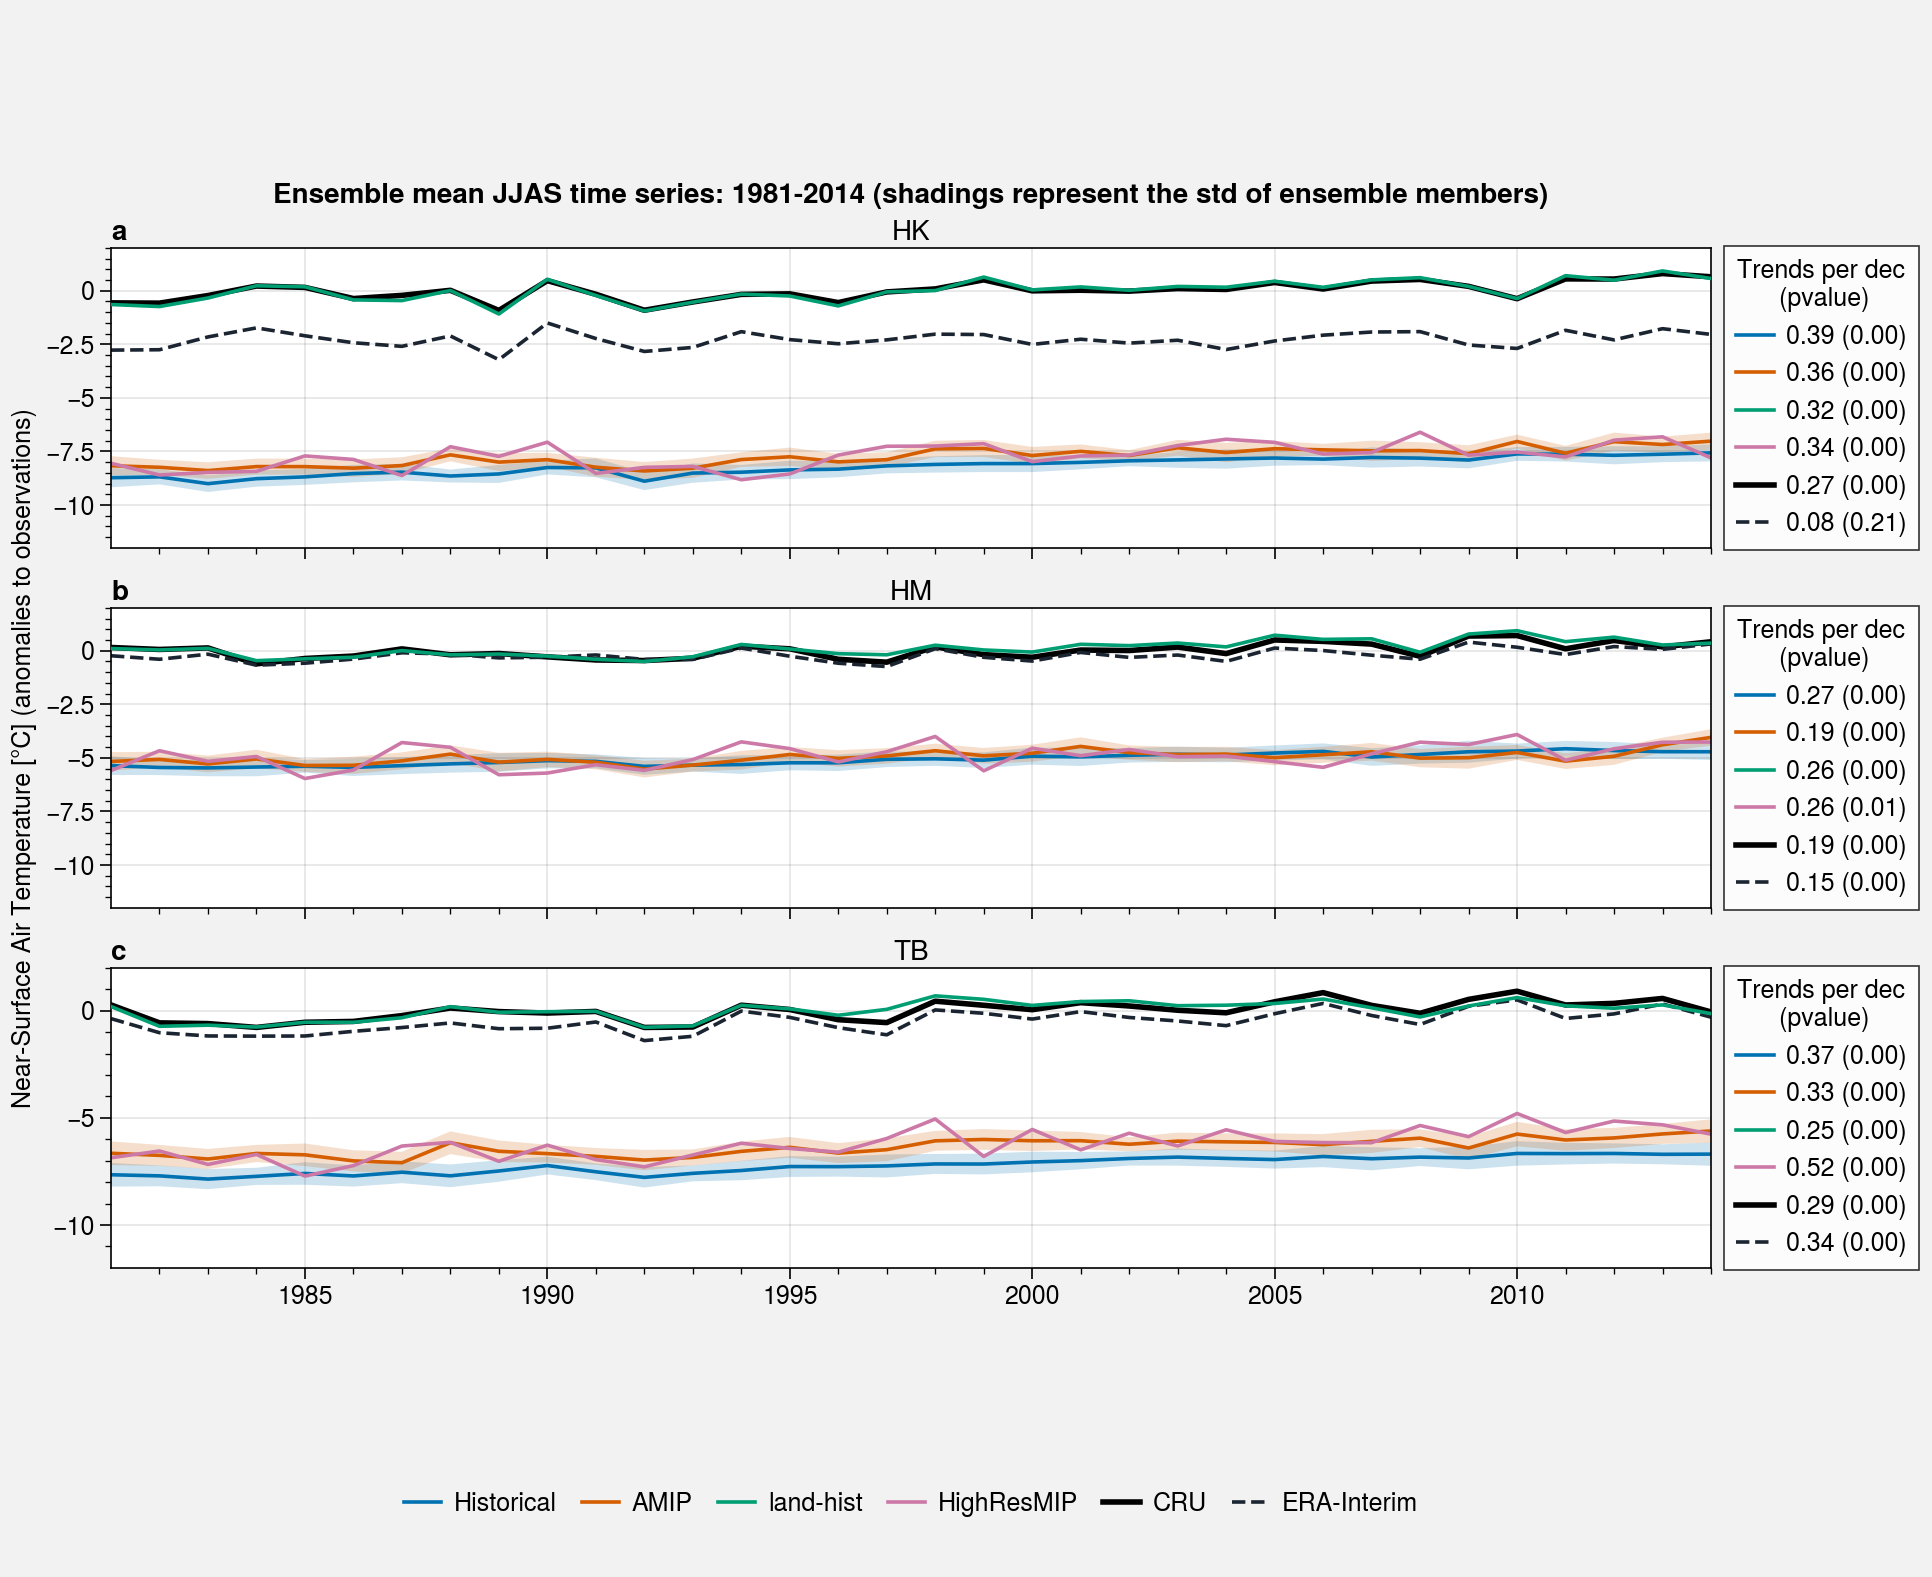

In [76]:
f, axs = plot.subplots(ncols=1, nrows=3, axwidth=8, axheight=1.5, share=3, hspace=0.3)

for i, ax in enumerate(axs):
    
    # Compute time series on the zone
    # Ensemble
    ym_historical_ens = (u.year_mean(u.spatial_average(da_historical_ens.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
              - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_amip_ens = (u.year_mean(u.spatial_average(da_amip_ens.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
        - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()


    # Not ensemble
    ym_land_hist = (u.year_mean(u.spatial_average(da_land_hist.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
         - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_HR_regrid = (u.year_mean(u.spatial_average(da_HR_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
         - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_obs_regrid = (u.year_mean(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
          - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_era_regrid = (u.year_mean(u.spatial_average(era_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
          - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()    
        
    
    # historical
    x = ym_historical_ens.year
    y = ym_historical_ens.mean('realization')
    std = ym_historical_ens.std('realization')
    h1 = y.plot(ax=ax, label='Historical')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    r = stats.linregress(x, y)
    t1 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # amip
    x = ym_amip_ens.year
    y = ym_amip_ens.mean('realization')
    std = ym_historical_ens.std('realization')
    h2 = y.plot(ax=ax, label='AMIP')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    r = stats.linregress(x, y)
    t2 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # land_hist
    y = ym_land_hist
    h3 = y.plot(ax=ax, label='land-hist', zorder=10)
    r = stats.linregress(x, y)
    t3 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # HighResMIP
    y = ym_HR_regrid
    h4 = y.plot(ax=ax, label='HighResMIP')
    r = stats.linregress(x, y)
    t4 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # Obs
    y = ym_obs_regrid
    h5 = y.plot(ax=ax, label=obs_name, color='black', linewidth=2)
    r = stats.linregress(x, y)
    t5 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # ERA
    y = ym_era_regrid
    h6 = y.plot(ax=ax, label='ERA-Interim', color='dark', linestyle='--')
    r = stats.linregress(x, y)
    t6 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    
    ax.format(title=titles[i])
    hs = [h1, h2, h3, h4, h5, h6]
    hs_trends = [h1[0], h2[0], h3[0], h4[0], h5[0], h6[0]] # keep only the handles (not the label)

    ax.legend(hs_trends, [t1, t2, t3, t4, t5, t6], title='Trends per dec\n      (pvalue)', loc='r', ncols=1)


axs.format(
    xlabel='', ylabel=var_label + ' (anomalies to observations)',
    suptitle='Ensemble mean '+season+' time series: 1981-2014 (shadings represent the std of ensemble members)', abc=True,
    ylim=(-12,2)
)
    
f.legend(hs, loc='b', ncols=6, order='F', center=False, frame=False)

# f.save('img/'+var+'/ym_ens_zones_'+var+'_ano-obs_'+season+'.png')
# f.save('img/'+var+'/ym_ens_zones_'+var+'_ano-obs_'+season+'.pdf')

## anomalies - u.clim(#) ("unbiased")

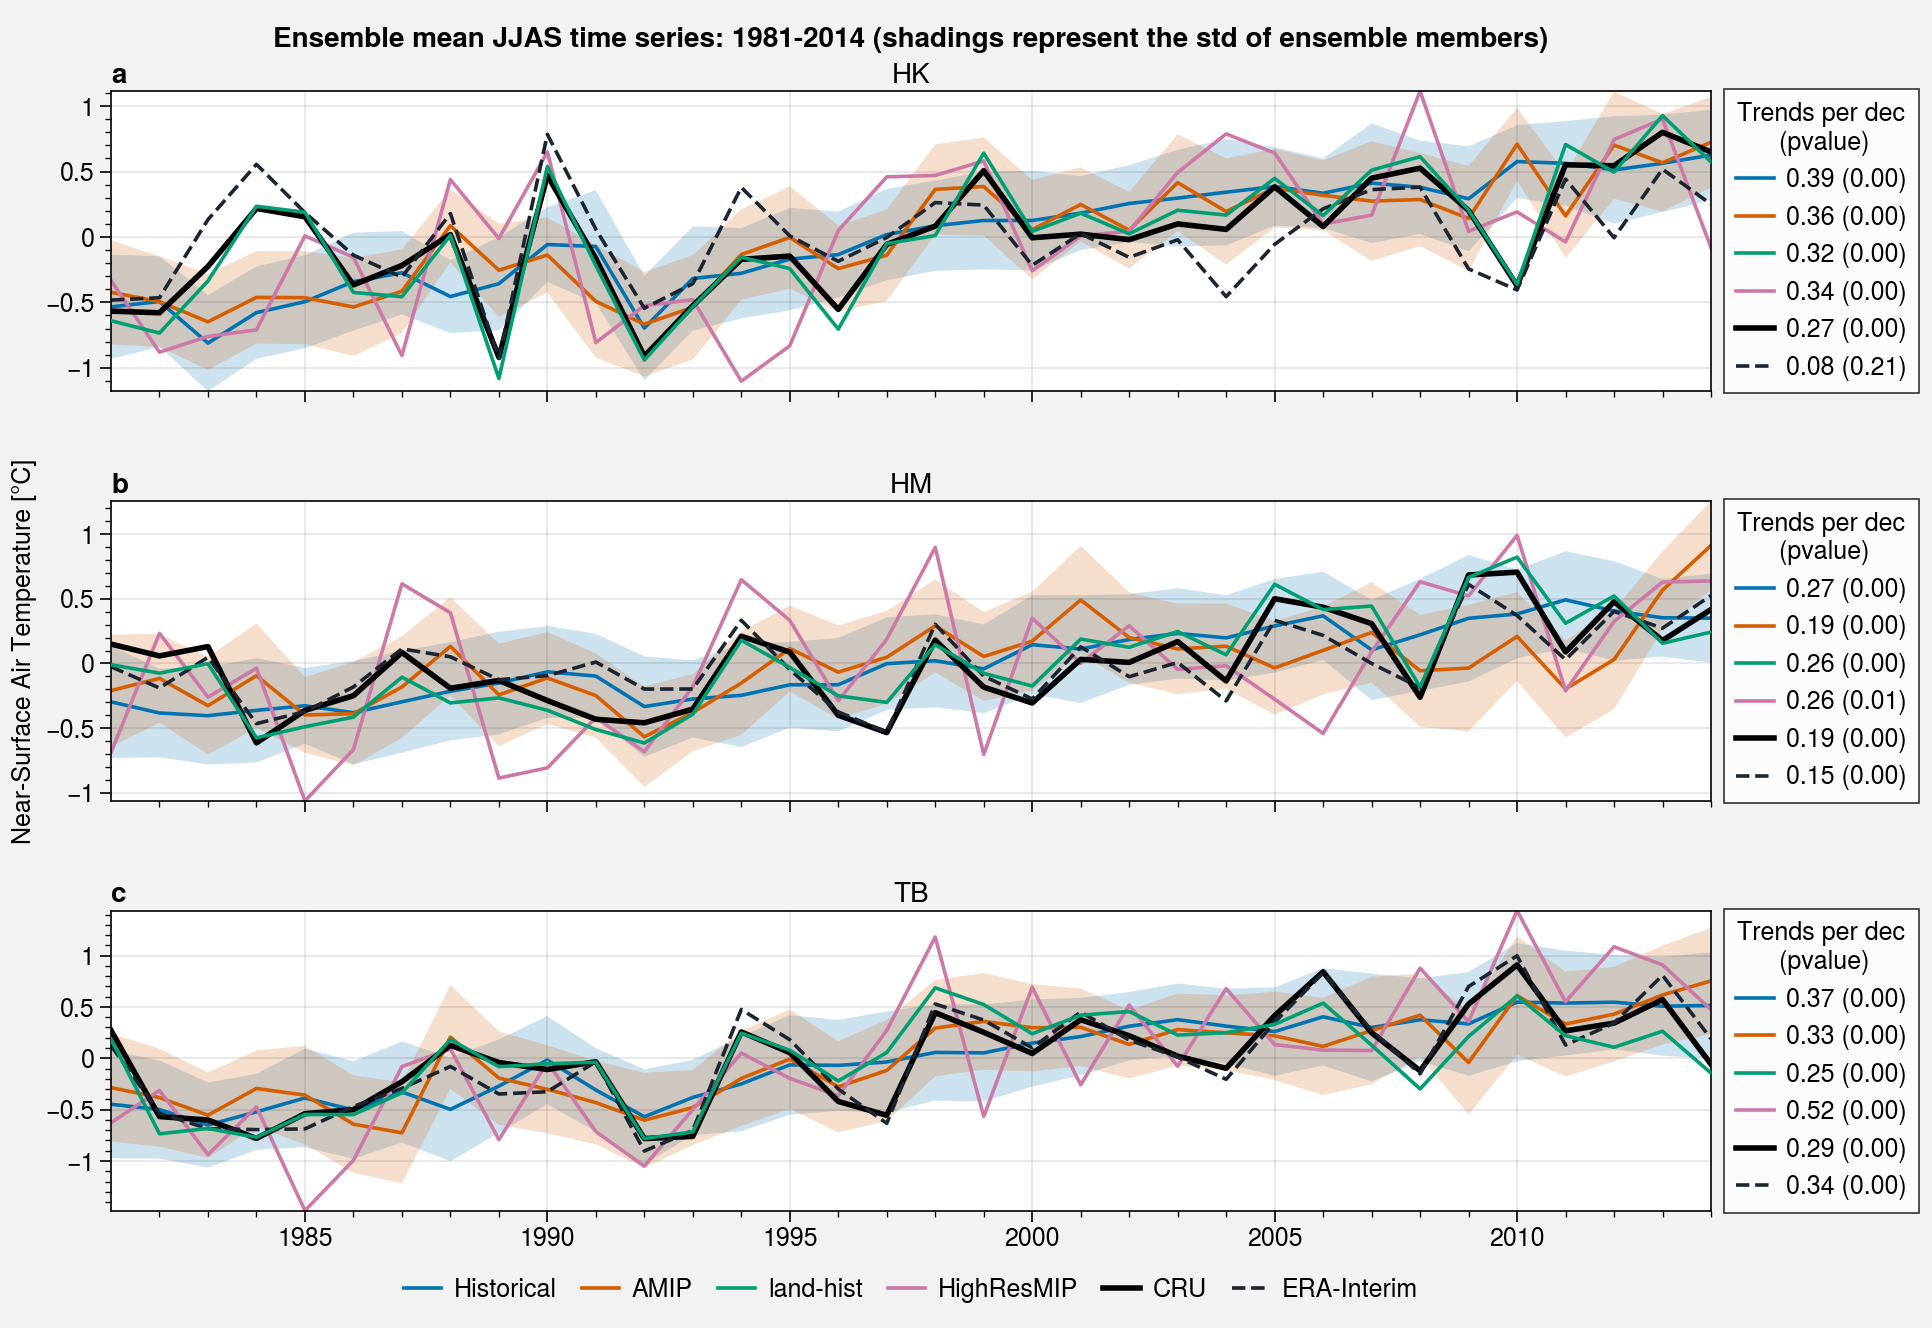

In [63]:
f, axs = plot.subplots(ncols=1, nrows=3, axwidth=8, axheight=1.5, share=3)

for i, ax in enumerate(axs):
    
    # Compute time series on the zone
    # Ensemble
    ym_historical_ens = (u.year_mean(u.spatial_average(da_historical_ens.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
              - u.custom_season_clim(u.spatial_average(da_historical_ens.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_amip_ens = (u.year_mean(u.spatial_average(da_amip_ens.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
        - u.custom_season_clim(u.spatial_average(da_amip_ens.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()


    # Not ensemble
    ym_land_hist = (u.year_mean(u.spatial_average(da_land_hist.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
         - u.custom_season_clim(u.spatial_average(da_land_hist.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_HR_regrid = (u.year_mean(u.spatial_average(da_HR_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
         - u.custom_season_clim(u.spatial_average(da_HR_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_obs_regrid = (u.year_mean(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
          - u.custom_season_clim(u.spatial_average(obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()
    ym_era_regrid = (u.year_mean(u.spatial_average(era_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season) \
          - u.custom_season_clim(u.spatial_average(era_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])), season=season)).load()    
        
    
    # historical
    x = ym_historical_ens.year
    y = ym_historical_ens.mean('realization')
    std = ym_historical_ens.std('realization')
    h1 = y.plot(ax=ax, label='Historical')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    r = stats.linregress(x, y)
    t1 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # amip
    x = ym_amip_ens.year
    y = ym_amip_ens.mean('realization')
    std = ym_historical_ens.std('realization')
    h2 = y.plot(ax=ax, label='AMIP')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    r = stats.linregress(x, y)
    t2 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # land_hist
    y = ym_land_hist
    h3 = y.plot(ax=ax, label='land-hist', zorder=10)
    r = stats.linregress(x, y)
    t3 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # HighResMIP
    y = ym_HR_regrid
    h4 = y.plot(ax=ax, label='HighResMIP')
    r = stats.linregress(x, y)
    t4 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # Obs
    y = ym_obs_regrid
    h5 = y.plot(ax=ax, label=obs_name, color='black', linewidth=2)
    r = stats.linregress(x, y)
    t5 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    # ERA
    y = ym_era_regrid
    h6 = y.plot(ax=ax, label='ERA-Interim', color='dark', linestyle='--')
    r = stats.linregress(x, y)
    t6 = '{:.2f}'.format(r.slope*10) + ' ({:.2f})'.format(r.pvalue)
    
    
    ax.format(title=titles[i])
    hs = [h1, h2, h3, h4, h5, h6]
    hs_trends = [h1[0], h2[0], h3[0], h4[0], h5[0], h6[0]] # keep only the handles (not the label)

    ax.legend(hs_trends, [t1, t2, t3, t4, t5, t6], title='Trends per dec\n      (pvalue)', loc='r', ncols=1)


axs.format(
    xlabel='', ylabel=var_label,
    suptitle='Ensemble mean '+season+' time series: 1981-2014 (shadings represent the std of ensemble members)', abc=True,
#     ylim=(-11,11)
)
    
f.legend(hs, loc='b', ncols=6, order='F', center=False, frame=False)

# f.save('img/'+var+'/ym_ens_zones_'+var+'_'+season+'.png')
# f.save('img/'+var+'/ym_ens_zones_'+var+'_'+season+'.pdf')

# Trends
[#Load-ensemble-mean](#Load-ensemble-mean)  
[#Check-stations](#Check-stations)  
[#Check-monthly-data](#Check-monthly-data)  
[#Annual-Climatology](#Annual-Climatology)  
[#Bias](#Bias)  
[#Link-with-orography?](#Link-with-orography?)  
[#Annual-cycle-ensemble-mean](#Annual-cycle-ensemble-mean)  
[#Time-series](#Time-series)  
[#Trends](#Trends)   

Linregress: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html  
Issues linregress: https://github.com/scipy/scipy/issues/7074  
How to parallelize/vectorize: https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset
Xarray / Dask example: http://martin-jung.github.io/post/2018-xarrayregression/

In [78]:
def corr(x, y, dim):
    return xr.apply_ufunc(
        stats.linregress, x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True
    )

In [79]:
# Add directly the results of linregress to arrays
# Compute year mean first
latlim=(10,50)
lonlim=(60,110)

ym_historical = u.year_mean(da_historical.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_historical.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_historical.year, ym_historical, 'year')):
    ym_historical[arr_name] = arr

ym_amip = u.year_mean(da_amip.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_amip.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_amip.year, ym_amip, 'year')):
    ym_amip[arr_name] = arr

ym_land_hist = u.year_mean(da_land_hist.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_land_hist.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_land_hist.year, ym_land_hist, 'year')):
    ym_land_hist[arr_name] = arr

ym_HR_regrid = u.year_mean(da_HR_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_HR_regrid.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_HR_regrid.year, ym_HR_regrid, 'year')):
    ym_HR_regrid[arr_name] = arr

ym_HR = u.year_mean(da_HR.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_HR.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_HR.year, ym_HR, 'year')):
    ym_HR[arr_name] = arr
    
ym_obs_regrid = u.year_mean(obs_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_obs_regrid.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_obs_regrid.year, ym_obs_regrid, 'year')):
    ym_obs_regrid[arr_name] = arr

ym_obs = u.year_mean(obs.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_obs.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_obs.year, ym_obs, 'year')):
    ym_obs[arr_name] = arr

ym_era_regrid = u.year_mean(era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_era_regrid.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_era_regrid.year, ym_era_regrid, 'year')):
    ym_era_regrid[arr_name] = arr

ym_era = u.year_mean(era.sel(lat=slice(latlim[1],latlim[0]), lon=slice(lonlim[0],lonlim[1])), season=season)
ym_era.load()
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_era.year, ym_era, 'year')):
    ym_era[arr_name] = arr

In [80]:
# We remove HR for keeping the resolution

concat = xr.concat(
    [
        ym_historical,
        ym_amip,
        ym_land_hist,
    ],
    pd.Index(
        [
            'Historical (32)',
            'AMIP (21)',
            'land-hist (1)',
        ], 
        name='exp'
    )
)

In [81]:
concat.slope.max()*10

<xarray.DataArray 'slope' ()>
array(1.07677422)
Coordinates:
    height   float64 2.0

In [82]:
concat.slope.min()*10

<xarray.DataArray 'slope' ()>
array(-0.41298122)
Coordinates:
    height   float64 2.0

In [83]:
ym_obs.slope.max()*10

<xarray.DataArray 'slope' ()>
array(0.70476783)

In [84]:
ym_obs.slope.min()*10

<xarray.DataArray 'slope' ()>
array(-0.19780593)

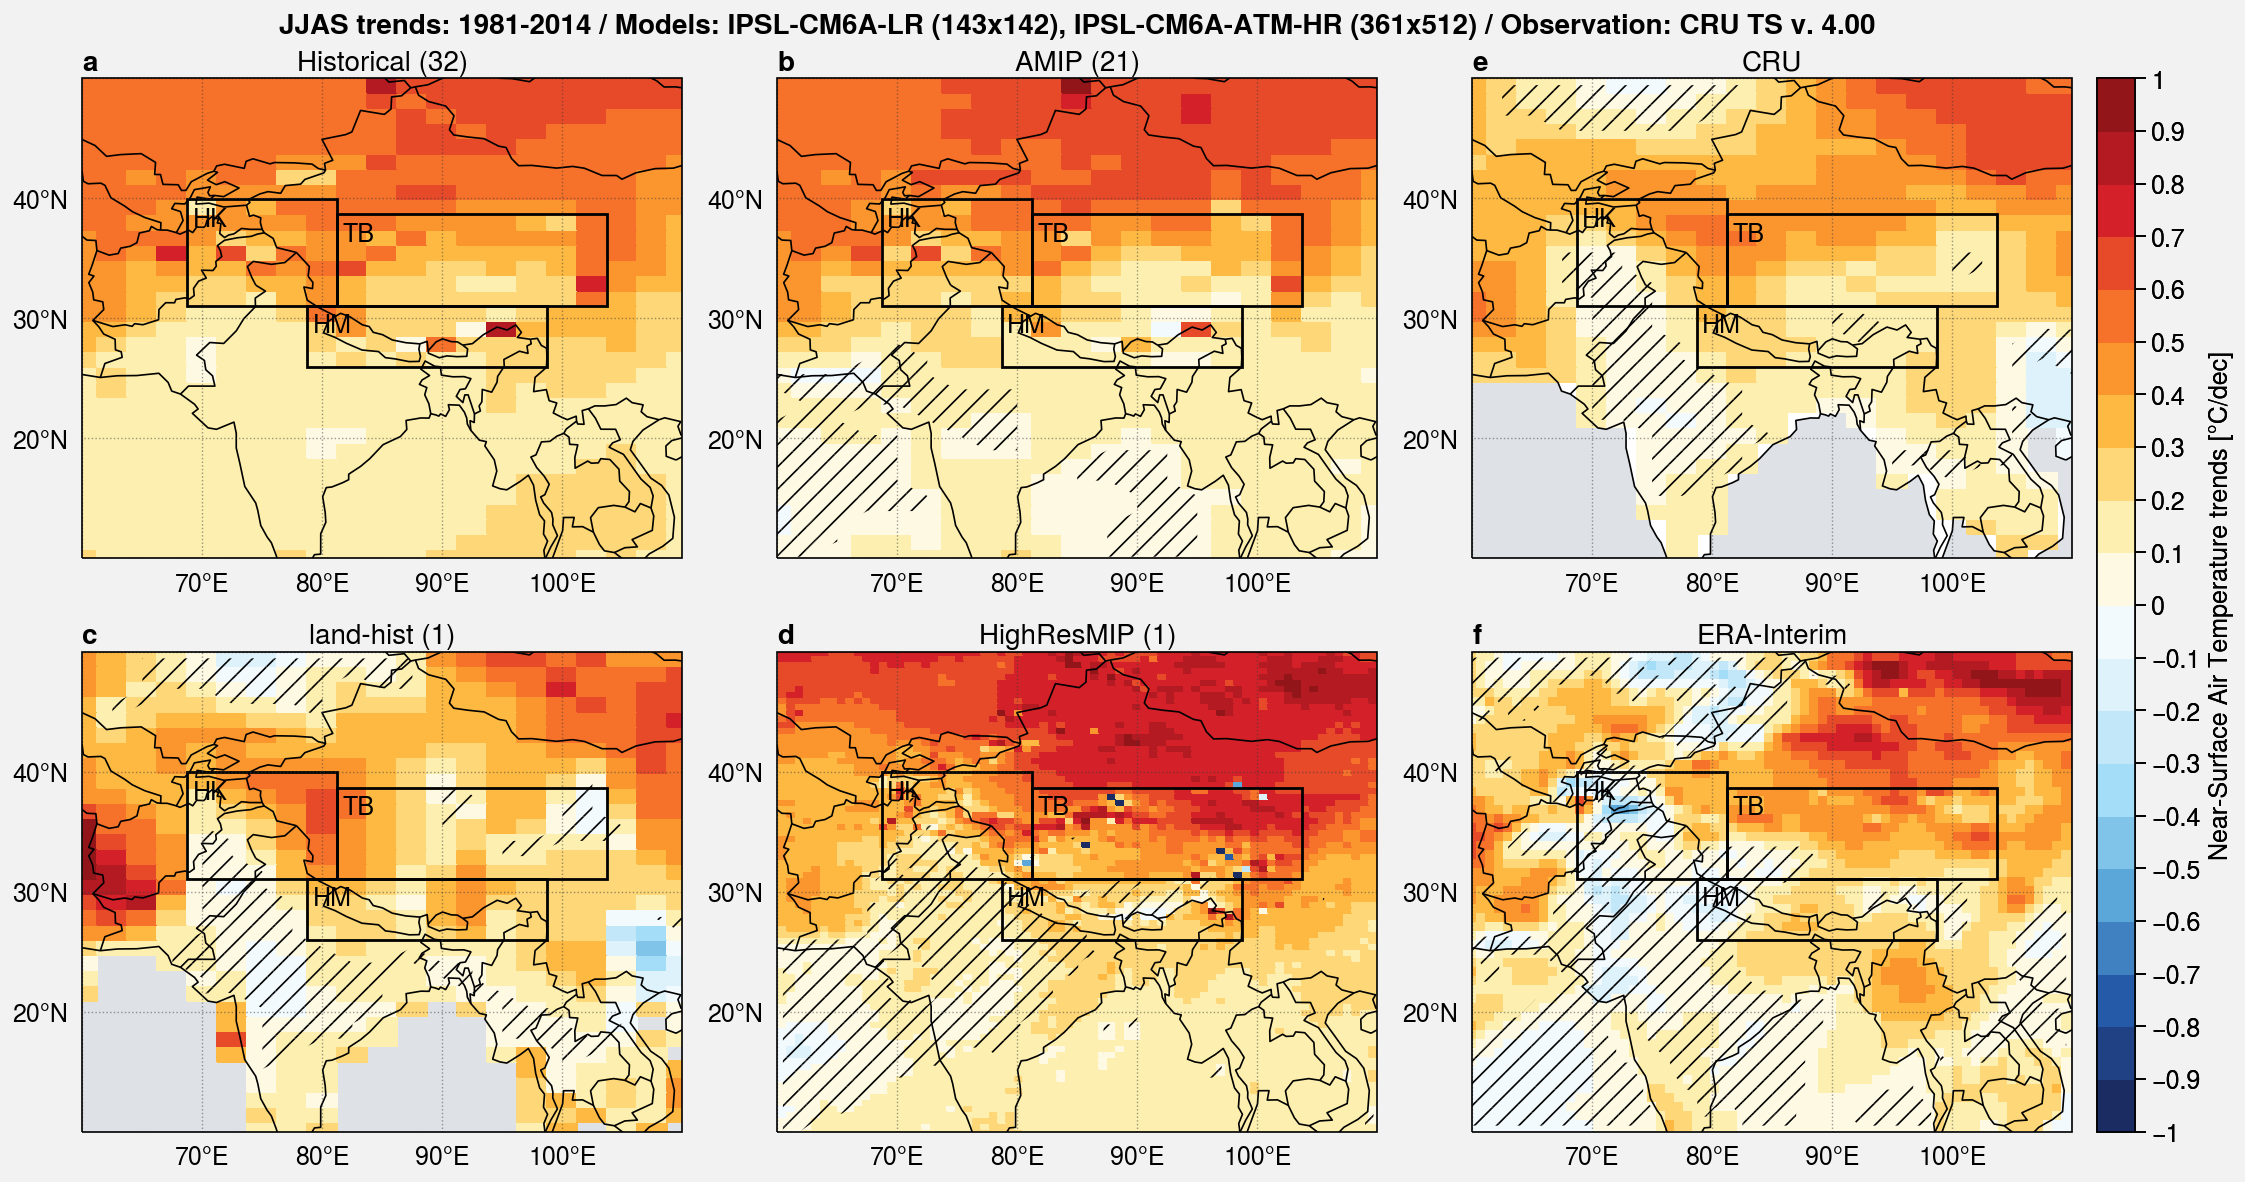

In [85]:
# Final plot

f, axs = plot.subplots([[1, 2, 5], [3, 4, 6]], proj='cyl', share=3, axwidth=3)

cmap='ColdHot'
levels=plot.arange(-1,1,0.1)
extend='neither'

for i, ax in enumerate(axs):
    if i < 3:
        m = ax.pcolormesh(concat.isel(exp=i).slope*10, cmap=cmap, levels=levels, extend=extend)
        if not (np.isnan(concat.isel(exp=i).pvalue.where(concat.isel(exp=i).pvalue>0.05)) == True ).all():
            ax.contourf(concat.isel(exp=i).pvalue.where(concat.isel(exp=i).pvalue>0.05), hatches=['///'], alpha=0)
        ax.format(title=str(concat.isel(exp=i).exp.values))
    
axs[3].pcolormesh(ym_HR.slope*10, cmap=cmap, levels=levels, extend=extend)
axs[3].contourf(ym_HR.pvalue.where(ym_HR.pvalue>0.05), hatches=['///'], alpha=0)
axs[3].format(title='HighResMIP (1)')

axs[4].pcolormesh(ym_obs_regrid.slope*10, cmap=cmap, levels=levels, extend=extend)
axs[4].contourf(ym_obs_regrid.pvalue.where(ym_obs_regrid.pvalue>0.05), hatches=['///'], alpha=0)
axs[4].format(title=obs_name)

axs[5].pcolormesh(ym_era.slope*10, cmap=cmap, levels=levels, extend=extend)
axs[5].contourf(ym_era.pvalue.where(ym_era.pvalue>0.05), hatches=['///'], alpha=0)
axs[5].format(title='ERA-Interim')

f.colorbar(m, label=var_label_trends, formatter=('simple', 3))

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

# Format
axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=season+" trends: 1981-2014 / Models: IPSL-CM6A-LR (143x142), IPSL-CM6A-ATM-HR (361x512) / Observation: "+obs_longname,
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/'+season+'_trends_'+var+'_IPSL_CMIP6.png')
# f.save('img/'+var+'/'+season+'_trends_'+var+'_IPSL_CMIP6.pdf')

## Compute trends for all members

In [22]:
realization = '*'
da_historical_ens = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='nested', concat_dim='realization', parallel=True
).sel(time=period, lon=slice(lonlim[0],lonlim[1]), lat=slice(latlim[0],latlim[1]))[var].load()

In [86]:
ym_historical_ens = u.year_mean(da_historical_ens , season=season)
ym_historical_ens.load()

<xarray.DataArray (realization: 32, year: 34, lat: 32, lon: 21)>
array([[[[26.15218641, 26.25232884, 26.30658134, ..., 26.69742922,
          27.65716828, 27.69842354],
         [26.14684883, 26.31323592, 26.36469381, ..., 25.85322646,
          24.90493124, 27.84299431],
         [26.19445376, 26.34128783, 26.50993397, ..., 25.98157489,
          24.10802522, 28.08246625],
         ...,
         [23.97649996, 24.86175537, 23.91354495, ..., 13.25667259,
          13.29215978, 15.62781212],
         [21.80161398, 22.7177887 , 22.22928182, ..., 14.22621855,
          11.16212138, 13.04181258],
         [20.02646099, 21.5063419 , 21.04135657, ..., 14.84913335,
          13.17724084, 11.30038477]],

        [[26.07578615, 26.28955678, 26.45082518, ..., 26.79563829,
          27.76317284, 27.86466905],
         [26.03640947, 26.32505248, 26.45870722, ..., 25.90174315,
          24.98980163, 27.95863117],
         [26.05344528, 26.26703606, 26.44416409, ..., 26.04571758,
          24.0716125 , 28.12791318],
         ...,
         [24.39960117, 25.08366594, 23.79967887, ..., 12.66986159,
          12.82433857, 15.04836986],
         [22.46053052, 23.13835894, 22.42957669, ..., 13.2156227 ,
          10.24084673, 12.00629638],
         [20.63621171, 22.3401069 , 21.38908686, ..., 13.51924033,
          12.18973954, 10.43173468]],

        [[26.11825537, 26.31709915, 26.4261297 , ..., 26.73508541,
          27.66994289, 27.62624697],
         [26.20373235, 26.38866062, 26.43770312, ..., 25.79655932,
          24.84602856, 27.76300624],
         [26.19854436, 26.426643  , 26.58351886, ..., 25.89002165,
          24.00071616, 27.93258267],
         ...,
         [22.97124219, 23.52912853, 22.68026783, ..., 12.00124422,
          12.13421256, 14.1024385 ],
         [21.11439114, 21.80507147, 21.07905679, ..., 12.84093013,
           9.71165341, 11.35503525],
         [19.0665731 , 20.6005214 , 19.67892931, ..., 13.50719089,
          11.70076789,  9.67100425]],

        ...,

        [[26.28944422, 26.43362252, 26.53753412, ..., 27.12374403,
          28.14274922, 28.20761834],
         [26.21221073, 26.33886268, 26.437064  , ..., 26.30290147,
          25.41415906, 28.33137937],
         [26.18436269, 26.27826303, 26.40544128, ..., 26.42550159,
          24.48255895, 28.48348749],
         ...,
         [25.06676546, 25.64998314, 24.40540326, ..., 14.82168579,
          14.52984169, 16.92938658],
         [22.85562534, 23.48599718, 22.86181941, ..., 15.61853528,
          12.28561727, 13.75850915],
         [20.79223933, 22.56777479, 21.72956823, ..., 15.9867256 ,
          14.35036306, 12.10698712]],

        [[26.55093809, 26.72572952, 26.86745015, ..., 27.3037397 ,
          28.14504355, 28.175346  ],
         [26.46723338, 26.69228275, 26.82532339, ..., 26.38708946,
          25.43302517, 28.28858197],
         [26.49395827, 26.69614448, 26.85031178, ..., 26.4829827 ,
          24.53338423, 28.49115741],
         ...,
         [25.04188763, 25.98752231, 24.47630135, ..., 14.91254838,
          14.7651855 , 16.9031192 ],
         [23.19269899, 24.06048534, 23.26279487, ..., 15.93259993,
          12.74610451, 14.38388587],
         [21.77238039, 23.29969137, 22.21290363, ..., 16.81364991,
          14.88937903, 12.8320265 ]],

        [[26.92163736, 27.17527896, 27.24791805, ..., 27.3713534 ,
          28.36513407, 28.39303039],
         [26.96659701, 27.14659919, 27.25768543, ..., 26.44802406,
          25.56619363, 28.44997168],
         [26.98875552, 27.14301012, 27.28971087, ..., 26.5213458 ,
          24.59017369, 28.64649963],
         ...,
         [26.4698809 , 27.12017422, 25.77530408, ..., 14.249138  ,
          14.22442552, 16.34008639],
         [24.68958095, 25.44292888, 24.65800801, ..., 14.91340612,
          12.0585935 , 13.67859587],
         [23.19987538, 24.81543219, 23.75166671, ..., 15.42712703,
          14.17471889, 11.70410081]]],


       [[[25.76088777, 25.87851477, 25.96289012, ..., 26.33503848,
          27

In [87]:
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], corr(ym_historical_ens.year, ym_historical_ens, 'year')):
    ym_historical_ens[arr_name] = arr

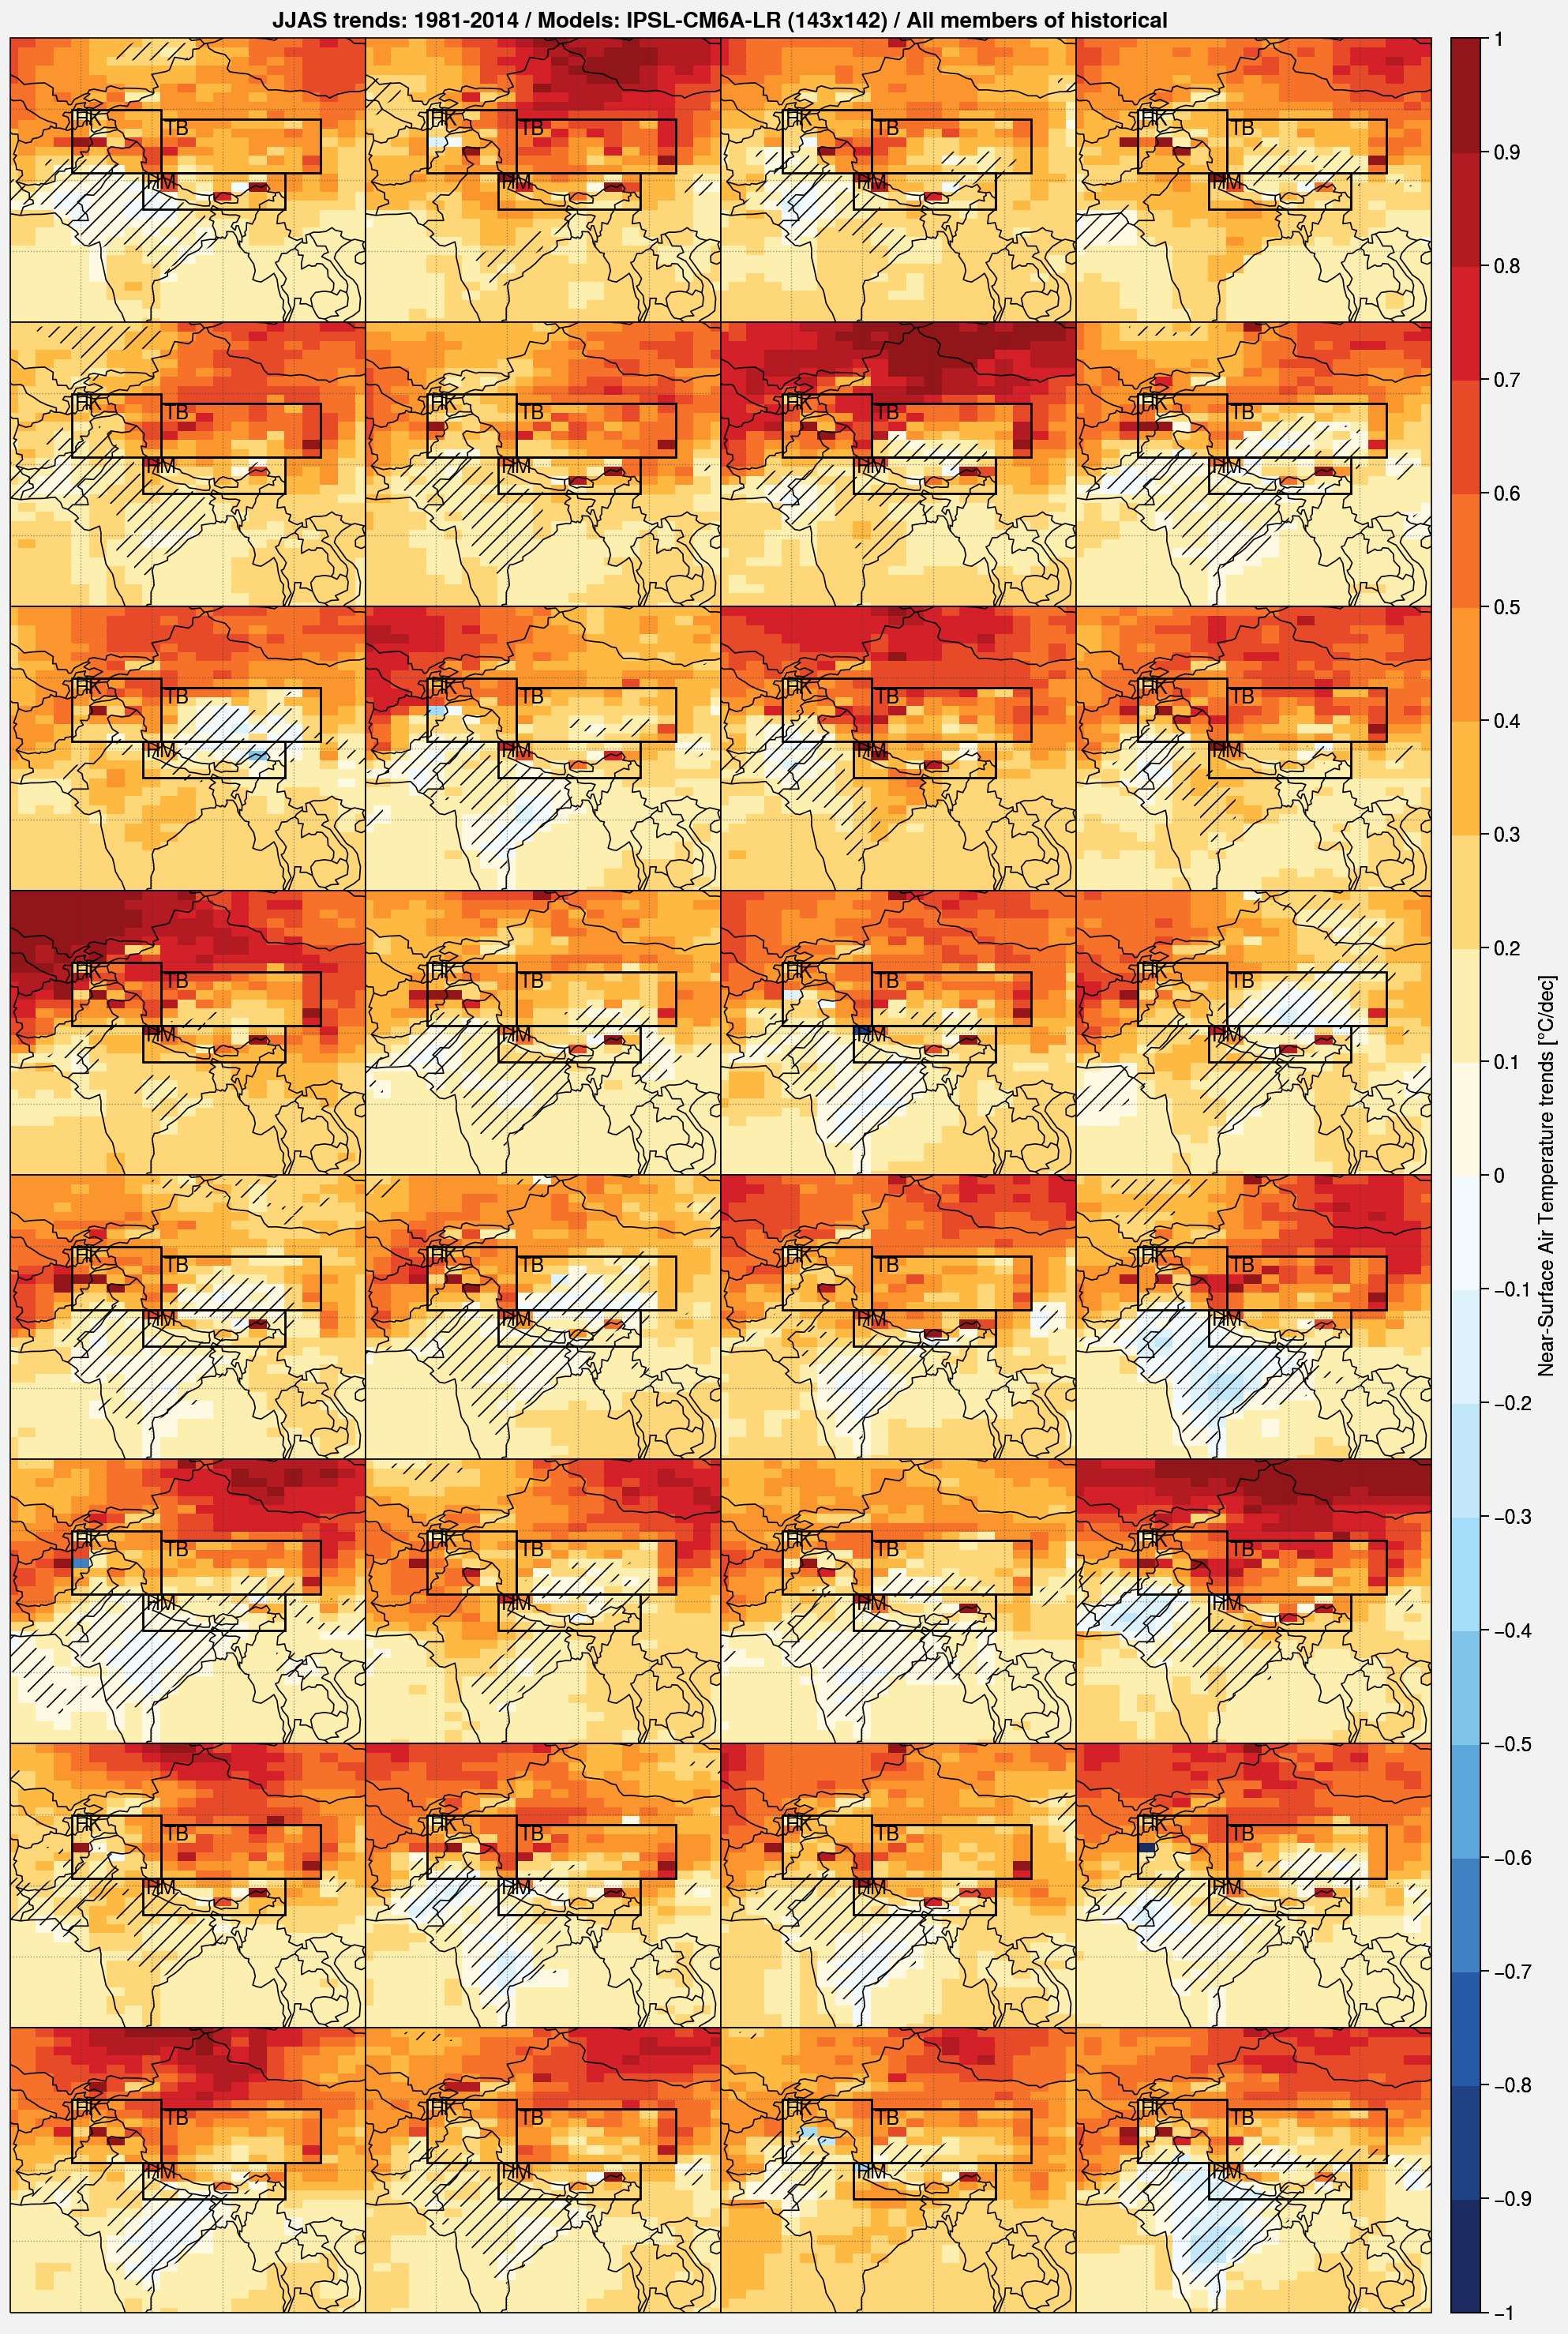

In [88]:
# Final plot

f, axs = plot.subplots(ncols=4, nrows=8, proj='cyl', space=0)

cmap='ColdHot'
levels=plot.arange(-1,1,0.1)
extend='neither'

for i, ax in enumerate(axs):
    m = ax.pcolormesh(ym_historical_ens[i].slope*10, cmap=cmap, levels=levels, extend=extend)
    if not (np.isnan(ym_historical_ens[i].pvalue.where(ym_historical_ens[i].pvalue>0.05)) == True ).all():
        ax.contourf(
            ym_historical_ens[i].pvalue.where(ym_historical_ens[i].pvalue>0.05), hatches=['///'], alpha=0
        )
    ax.format(title='')

f.colorbar(m, label=var_label_trends, formatter=('simple', 3))

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

# Format
axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle=season+" trends: 1981-2014 / Models: IPSL-CM6A-LR (143x142) / All members of historical",
    lonlines=10, latlines=10, abc=False, latlim=latlim, lonlim=lonlim
)

# f.save('img/'+var+'/'+season+'_trends_'+var+'_IPSL_CMIP6_ens_historical.png')
# f.save('img/'+var+'/'+season+'_trends_'+var+'_IPSL_CMIP6_ens_historical.pdf')